In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import EPCE
import glob
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

import os
import time

from data_loader import HDRDataset
from model import FHDR
import potions
from util import (
    load_checkpoint,
    make_required_directories,
    mu_tonemap,
    save_checkpoint,
    save_hdr_image,
    save_ldr_image,
    update_lr,

)



In [5]:
import sklearn

ImportError: cannot import name 'Memory' from 'joblib' (unknown location)

In [6]:
import sklearn
import scipy

print(sklearn.__version__)
print(scipy.__version__)

ImportError: cannot import name 'Memory' from 'joblib' (unknown location)

In [7]:
from sklearn.model_selection import train_test_split

ImportError: cannot import name 'Memory' from 'joblib' (unknown location)

In [10]:

opt = potions.Options().parse()



In [4]:
dataset = HDRDataset(mode="train", opt=opt)

# split dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# create separate data loaders for training and validation
train_data_loader = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False)
print("Training samples: ", len(train_data_loader))
print("Validation samples: ", len(val_data_loader))



# Define the curve estimation model
model = EPCE.PPVisionTransformer()
# Define the loss function

l1 = torch.nn.L1Loss()
perceptual_loss = EPCE.VGGLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Set the device (CPU or GPU)
device = torch.device("cuda")



NameError: name 'train_test_split' is not defined

In [12]:
dataset = HDRDataset(mode="train", opt=opt)

data_loader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)

print("Training samples: ", len(data_loader))

# Define the curve estimation model
model = EPCE.PPVisionTransformer()
# Define the loss function

l1 = torch.nn.L1Loss()
perceptual_loss = EPCE.VGGLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Set the device (CPU or GPU)
device = torch.device("cuda")


Training samples:  850


c:\condaenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\condaenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# Move the model to the device
model.to(device)
# Set the model to training mode
model.train()
# Iterate over the dataset for multiple epochs
losses = []
losses_validation = []

opt.epochs = 1000
for epoch in range(opt.epochs):
    if epoch > opt.lr_decay_after:
        update_lr(optimizer, epoch, opt)
    total_loss = 0.0
    for batch in tqdm(train_data_loader):
        # Move the batch to the device
        optimizer.zero_grad()
        input = batch['ldr_image']
        input = input.to(device)
        output_true = batch['hdr_image']
        output_true = output_true.to(device)
        output = model(input)

        l1_loss = 0
        vgg_loss = 0

        # tonemapping ground truth ->
        # computing loss for n generated outputs (from n-iterations) ->

        for i in range(len(output)):
            l1_loss += l1(output[i], output_true[i])
            vgg_loss += perceptual_loss(output[i], output_true[i])
        # averaged over n iterations
        l1_loss /= len(output)
        vgg_loss /= len(output)
       # averaged over batches
        l1_loss = torch.mean(l1_loss)
        vgg_loss = torch.mean(vgg_loss)

        # FHDR loss function
        loss = l1_loss + (vgg_loss * 10)
        # backpropagate and step
        loss.backward()
        optimizer.step()
        # Accumulate the loss
        total_loss += loss.item()
    # Print the average loss for the epoch
    average_loss = total_loss / len(train_data_loader)
    losses.append(average_loss)

    # VALIDATION LOOP
    # set model to evaluation mode
    model.eval()
    val_losses = []
    with torch.no_grad():
        for val_batch, val_data in enumerate(val_data_loader):
            input_val = batch['ldr_image']
            input_val = input_val.to(device)
            ground_truth_val = batch['hdr_image']
            ground_truth_val = ground_truth_val.to(device)
            optimizer.zero_grad()

            output_val = model(input_val)

            # calculate validation loss
            l1_loss_val = 0
            vgg_loss_val = 0

            for i in range(len(output)):
              l1_loss_val += l1(output_val[i],ground_truth_val[i])
              vgg_loss_val += perceptual_loss(output_val[i], ground_truth_val[i])

        # averaged over n iterations
            l1_loss_val /= len(output_val)
            vgg_loss_val /= len(output_val)

        # averaged over batches
            l1_loss_val = torch.mean(l1_loss_val)
            vgg_loss_val = torch.mean(vgg_loss_val)

        # FHDR loss function
            val_loss = l1_loss_val + (vgg_loss_val * 10)
            val_losses.append(val_loss)

    # Calculate average validation loss for the entire validation dataset
    average_val_loss = sum(val_losses) / len(val_losses)
    print(f"Average validation Loss: {average_val_loss}")
    losses_validation.append(average_val_loss)
    print(f"Epoch [{epoch+1}/{opt.epochs}], Average Loss: {average_loss:.4f}")

    model.train()
    if epoch%10 == 0:
      save_hdr_image(
                img_tensor=output,
                batch=0,
                path="/content/drive/MyDrive/epce-hdr/res/genot"+str(epoch)+".hdr".format(
                    i
                ),
        )
      save_hdr_image(
                img_tensor=output_true,
                batch=0,
                path="/content/drive/MyDrive/epce-hdr/res/realot"+str(epoch)+".hdr".format(
                    i
                ),
            )



    # Calculate average validation loss for the entire validation dataset
    average_val_loss = sum(val_losses) / len(val_losses)
    print(f"Average validation Loss: {average_val_loss}")
    losses_validation.append(average_val_loss.item())


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]
/content/drive/MyDrive/epce-hdr/util.py:55: RuntimeWarning: invalid value encountered in divide
  scaled_mantissa = mantissa * 255.0 / brightest


Average validation Loss: 67.26266479492188
Epoch [1/1000], Average Loss: 78.6072
Average validation Loss: 67.26266479492188


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Average validation Loss: 35.719173431396484
Epoch [2/1000], Average Loss: 64.8635
Average validation Loss: 35.719173431396484


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Average validation Loss: 31.82997703552246
Epoch [3/1000], Average Loss: 57.9039
Average validation Loss: 31.82997703552246


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


Average validation Loss: 89.61791229248047
Epoch [4/1000], Average Loss: 59.4317
Average validation Loss: 89.61791229248047


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Average validation Loss: 34.20195007324219
Epoch [5/1000], Average Loss: 53.7440
Average validation Loss: 34.20195007324219


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 257.9534912109375
Epoch [6/1000], Average Loss: 65.9860
Average validation Loss: 257.9534912109375


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 87.25542449951172
Epoch [7/1000], Average Loss: 57.1644
Average validation Loss: 87.25542449951172


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 89.71257781982422
Epoch [8/1000], Average Loss: 56.1245
Average validation Loss: 89.71257781982422


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


Average validation Loss: 96.12278747558594
Epoch [9/1000], Average Loss: 55.2741
Average validation Loss: 96.12278747558594


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 23.47561264038086
Epoch [10/1000], Average Loss: 51.8582
Average validation Loss: 23.47561264038086


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 30.114309310913086
Epoch [11/1000], Average Loss: 52.4731
Average validation Loss: 30.114309310913086


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 15.674161911010742
Epoch [12/1000], Average Loss: 50.2608
Average validation Loss: 15.674161911010742


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 35.62763595581055
Epoch [13/1000], Average Loss: 54.0456
Average validation Loss: 35.62763595581055


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 17.59443473815918
Epoch [14/1000], Average Loss: 53.4174
Average validation Loss: 17.59443473815918


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 25.221372604370117
Epoch [15/1000], Average Loss: 51.6524
Average validation Loss: 25.221372604370117


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 251.7268524169922
Epoch [16/1000], Average Loss: 62.7765
Average validation Loss: 251.7268524169922


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 86.7455062866211
Epoch [17/1000], Average Loss: 54.5746
Average validation Loss: 86.7455062866211


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 22.75423240661621
Epoch [18/1000], Average Loss: 50.3703
Average validation Loss: 22.75423240661621


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 16.536144256591797
Epoch [19/1000], Average Loss: 49.4060
Average validation Loss: 16.536144256591797


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 61.40571212768555
Epoch [20/1000], Average Loss: 52.7718
Average validation Loss: 61.40571212768555


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 52.72028350830078
Epoch [21/1000], Average Loss: 51.8074
Average validation Loss: 52.72028350830078


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 26.77098846435547
Epoch [22/1000], Average Loss: 50.2448
Average validation Loss: 26.77098846435547


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 87.08480072021484
Epoch [23/1000], Average Loss: 52.2161
Average validation Loss: 87.08480072021484


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 15.583846092224121
Epoch [24/1000], Average Loss: 49.7269
Average validation Loss: 15.583846092224121


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 28.11998748779297
Epoch [25/1000], Average Loss: 48.5248
Average validation Loss: 28.11998748779297


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 56.614959716796875
Epoch [26/1000], Average Loss: 49.3905
Average validation Loss: 56.614959716796875


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 46.4251823425293
Epoch [27/1000], Average Loss: 49.1822
Average validation Loss: 46.4251823425293


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 43.12894821166992
Epoch [28/1000], Average Loss: 48.6134
Average validation Loss: 43.12894821166992


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 249.6412811279297
Epoch [29/1000], Average Loss: 58.4777
Average validation Loss: 249.6412811279297


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 86.95494079589844
Epoch [30/1000], Average Loss: 51.8035
Average validation Loss: 86.95494079589844


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 44.2791862487793
Epoch [31/1000], Average Loss: 51.6209
Average validation Loss: 44.2791862487793


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 12.45649528503418
Epoch [32/1000], Average Loss: 50.2658
Average validation Loss: 12.45649528503418


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 80.12307739257812
Epoch [33/1000], Average Loss: 53.4144
Average validation Loss: 80.12307739257812


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 23.52664566040039
Epoch [34/1000], Average Loss: 50.4565
Average validation Loss: 23.52664566040039


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 27.08661651611328
Epoch [35/1000], Average Loss: 49.5028
Average validation Loss: 27.08661651611328


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 13.52530288696289
Epoch [36/1000], Average Loss: 47.4783
Average validation Loss: 13.52530288696289


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 22.065685272216797
Epoch [37/1000], Average Loss: 47.8763
Average validation Loss: 22.065685272216797


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 44.01560592651367
Epoch [38/1000], Average Loss: 49.3894
Average validation Loss: 44.01560592651367


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 42.12400436401367
Epoch [39/1000], Average Loss: 50.5986
Average validation Loss: 42.12400436401367


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 26.698925018310547
Epoch [40/1000], Average Loss: 48.3387
Average validation Loss: 26.698925018310547


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 77.91915130615234
Epoch [41/1000], Average Loss: 48.4108
Average validation Loss: 77.91915130615234


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 14.785436630249023
Epoch [42/1000], Average Loss: 46.5332
Average validation Loss: 14.785436630249023


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 47.36689758300781
Epoch [43/1000], Average Loss: 47.4437
Average validation Loss: 47.36689758300781


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 70.01946258544922
Epoch [44/1000], Average Loss: 46.5762
Average validation Loss: 70.01946258544922


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 39.24419403076172
Epoch [45/1000], Average Loss: 44.6753
Average validation Loss: 39.24419403076172


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 15.613887786865234
Epoch [46/1000], Average Loss: 42.9440
Average validation Loss: 15.613887786865234


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 34.08622360229492
Epoch [47/1000], Average Loss: 41.7629
Average validation Loss: 34.08622360229492


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 16.030475616455078
Epoch [48/1000], Average Loss: 41.3427
Average validation Loss: 16.030475616455078


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 20.42707061767578
Epoch [49/1000], Average Loss: 42.3593
Average validation Loss: 20.42707061767578


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 231.72494506835938
Epoch [50/1000], Average Loss: 51.9599
Average validation Loss: 231.72494506835938


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 16.307666778564453
Epoch [51/1000], Average Loss: 38.2000
Average validation Loss: 16.307666778564453


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 16.172637939453125
Epoch [52/1000], Average Loss: 36.5386
Average validation Loss: 16.172637939453125


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 21.341726303100586
Epoch [53/1000], Average Loss: 37.6726
Average validation Loss: 21.341726303100586


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 22.421199798583984
Epoch [54/1000], Average Loss: 39.7958
Average validation Loss: 22.421199798583984


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 17.689868927001953
Epoch [55/1000], Average Loss: 36.1188
Average validation Loss: 17.689868927001953


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 32.43994903564453
Epoch [56/1000], Average Loss: 34.7670
Average validation Loss: 32.43994903564453


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 37.56238555908203
Epoch [57/1000], Average Loss: 34.5326
Average validation Loss: 37.56238555908203


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 65.18476867675781
Epoch [58/1000], Average Loss: 37.9715
Average validation Loss: 65.18476867675781


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 14.912328720092773
Epoch [59/1000], Average Loss: 33.4247
Average validation Loss: 14.912328720092773


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 11.143545150756836
Epoch [60/1000], Average Loss: 30.5398
Average validation Loss: 11.143545150756836


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 69.84376525878906
Epoch [61/1000], Average Loss: 38.2174
Average validation Loss: 69.84376525878906


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 18.199222564697266
Epoch [62/1000], Average Loss: 35.7762
Average validation Loss: 18.199222564697266


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Average validation Loss: 15.232236862182617
Epoch [63/1000], Average Loss: 32.4366
Average validation Loss: 15.232236862182617


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 46.88898849487305
Epoch [64/1000], Average Loss: 32.8395
Average validation Loss: 46.88898849487305


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 16.917011260986328
Epoch [65/1000], Average Loss: 30.6685
Average validation Loss: 16.917011260986328


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 17.576416015625
Epoch [66/1000], Average Loss: 31.1521
Average validation Loss: 17.576416015625


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 14.288436889648438
Epoch [67/1000], Average Loss: 31.0602
Average validation Loss: 14.288436889648438


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 18.970516204833984
Epoch [68/1000], Average Loss: 30.7851
Average validation Loss: 18.970516204833984


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 12.456596374511719
Epoch [69/1000], Average Loss: 27.8239
Average validation Loss: 12.456596374511719


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 12.971404075622559
Epoch [70/1000], Average Loss: 28.0627
Average validation Loss: 12.971404075622559


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 14.840511322021484
Epoch [71/1000], Average Loss: 28.1124
Average validation Loss: 14.840511322021484


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 39.332435607910156
Epoch [72/1000], Average Loss: 28.4075
Average validation Loss: 39.332435607910156


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 15.599300384521484
Epoch [73/1000], Average Loss: 26.7681
Average validation Loss: 15.599300384521484


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 104.28143310546875
Epoch [74/1000], Average Loss: 32.7727
Average validation Loss: 104.28143310546875


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 17.46509552001953
Epoch [75/1000], Average Loss: 22.3212
Average validation Loss: 17.46509552001953


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 15.878450393676758
Epoch [76/1000], Average Loss: 26.6167
Average validation Loss: 15.878450393676758


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 21.361799240112305
Epoch [77/1000], Average Loss: 27.2691
Average validation Loss: 21.361799240112305


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 20.741565704345703
Epoch [78/1000], Average Loss: 36.1808
Average validation Loss: 20.741565704345703


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 26.567974090576172
Epoch [79/1000], Average Loss: 49.2714
Average validation Loss: 26.567974090576172


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 21.23370361328125
Epoch [80/1000], Average Loss: 44.7663
Average validation Loss: 21.23370361328125


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 30.767929077148438
Epoch [81/1000], Average Loss: 37.8576
Average validation Loss: 30.767929077148438


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 17.410255432128906
Epoch [82/1000], Average Loss: 32.6010
Average validation Loss: 17.410255432128906


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 38.45176696777344
Epoch [83/1000], Average Loss: 30.3271
Average validation Loss: 38.45176696777344


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 7.717538356781006
Epoch [84/1000], Average Loss: 26.1573
Average validation Loss: 7.717538356781006


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 12.33657455444336
Epoch [85/1000], Average Loss: 26.1229
Average validation Loss: 12.33657455444336


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 10.390373229980469
Epoch [86/1000], Average Loss: 23.8428
Average validation Loss: 10.390373229980469


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 18.62794303894043
Epoch [87/1000], Average Loss: 22.9357
Average validation Loss: 18.62794303894043


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 99.75981140136719
Epoch [88/1000], Average Loss: 27.2038
Average validation Loss: 99.75981140136719


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 18.992938995361328
Epoch [89/1000], Average Loss: 25.2705
Average validation Loss: 18.992938995361328


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 17.46877098083496
Epoch [90/1000], Average Loss: 24.5746
Average validation Loss: 17.46877098083496


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 23.489715576171875
Epoch [91/1000], Average Loss: 22.0125
Average validation Loss: 23.489715576171875


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 33.13511657714844
Epoch [92/1000], Average Loss: 23.1590
Average validation Loss: 33.13511657714844


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 16.431930541992188
Epoch [93/1000], Average Loss: 19.7834
Average validation Loss: 16.431930541992188


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 9.154472351074219
Epoch [94/1000], Average Loss: 21.0354
Average validation Loss: 9.154472351074219


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 9.876178741455078
Epoch [95/1000], Average Loss: 18.4544
Average validation Loss: 9.876178741455078


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 19.743404388427734
Epoch [96/1000], Average Loss: 18.6826
Average validation Loss: 19.743404388427734


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 35.07257843017578
Epoch [97/1000], Average Loss: 22.7440
Average validation Loss: 35.07257843017578


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 16.743465423583984
Epoch [98/1000], Average Loss: 18.5482
Average validation Loss: 16.743465423583984


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 19.22542381286621
Epoch [99/1000], Average Loss: 18.1563
Average validation Loss: 19.22542381286621


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 9.022199630737305
Epoch [100/1000], Average Loss: 18.5972
Average validation Loss: 9.022199630737305


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 11.843463897705078
Epoch [101/1000], Average Loss: 19.1695
Average validation Loss: 11.843463897705078
Learning rate decayed. Updated LR is: 0.000200


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 7.282932281494141
Epoch [102/1000], Average Loss: 18.6070
Average validation Loss: 7.282932281494141
Learning rate decayed. Updated LR is: 0.000200


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 11.825756072998047
Epoch [103/1000], Average Loss: 21.0110
Average validation Loss: 11.825756072998047
Learning rate decayed. Updated LR is: 0.000199


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 8.316293716430664
Epoch [104/1000], Average Loss: 23.4263
Average validation Loss: 8.316293716430664
Learning rate decayed. Updated LR is: 0.000199


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 29.669239044189453
Epoch [105/1000], Average Loss: 26.2440
Average validation Loss: 29.669239044189453
Learning rate decayed. Updated LR is: 0.000199


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 9.108991622924805
Epoch [106/1000], Average Loss: 29.6615
Average validation Loss: 9.108991622924805
Learning rate decayed. Updated LR is: 0.000199


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 16.896991729736328
Epoch [107/1000], Average Loss: 26.6526
Average validation Loss: 16.896991729736328
Learning rate decayed. Updated LR is: 0.000198


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 16.800634384155273
Epoch [108/1000], Average Loss: 27.0656
Average validation Loss: 16.800634384155273
Learning rate decayed. Updated LR is: 0.000198


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 41.14623260498047
Epoch [109/1000], Average Loss: 34.4746
Average validation Loss: 41.14623260498047
Learning rate decayed. Updated LR is: 0.000198


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 25.736446380615234
Epoch [110/1000], Average Loss: 32.6084
Average validation Loss: 25.736446380615234
Learning rate decayed. Updated LR is: 0.000198


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 20.582195281982422
Epoch [111/1000], Average Loss: 30.5291
Average validation Loss: 20.582195281982422
Learning rate decayed. Updated LR is: 0.000198


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 9.139323234558105
Epoch [112/1000], Average Loss: 27.8442
Average validation Loss: 9.139323234558105
Learning rate decayed. Updated LR is: 0.000197


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.929262161254883
Epoch [113/1000], Average Loss: 24.8926
Average validation Loss: 13.929262161254883
Learning rate decayed. Updated LR is: 0.000197


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 16.99917221069336
Epoch [114/1000], Average Loss: 25.9025
Average validation Loss: 16.99917221069336
Learning rate decayed. Updated LR is: 0.000197


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 34.47577667236328
Epoch [115/1000], Average Loss: 24.0660
Average validation Loss: 34.47577667236328
Learning rate decayed. Updated LR is: 0.000197


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 18.38947105407715
Epoch [116/1000], Average Loss: 22.5160
Average validation Loss: 18.38947105407715
Learning rate decayed. Updated LR is: 0.000196


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.488256454467773
Epoch [117/1000], Average Loss: 28.7847
Average validation Loss: 12.488256454467773
Learning rate decayed. Updated LR is: 0.000196


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.093635559082031
Epoch [118/1000], Average Loss: 23.7742
Average validation Loss: 10.093635559082031
Learning rate decayed. Updated LR is: 0.000196


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.749229431152344
Epoch [119/1000], Average Loss: 19.7022
Average validation Loss: 9.749229431152344
Learning rate decayed. Updated LR is: 0.000196


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.07656478881836
Epoch [120/1000], Average Loss: 21.9141
Average validation Loss: 13.07656478881836
Learning rate decayed. Updated LR is: 0.000196


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.700438499450684
Epoch [121/1000], Average Loss: 19.0988
Average validation Loss: 8.700438499450684
Learning rate decayed. Updated LR is: 0.000195


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 15.275847434997559
Epoch [122/1000], Average Loss: 18.1213
Average validation Loss: 15.275847434997559
Learning rate decayed. Updated LR is: 0.000195


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.858028411865234
Epoch [123/1000], Average Loss: 16.9059
Average validation Loss: 10.858028411865234
Learning rate decayed. Updated LR is: 0.000195


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.222346305847168
Epoch [124/1000], Average Loss: 17.5717
Average validation Loss: 11.222346305847168
Learning rate decayed. Updated LR is: 0.000195


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 18.45844078063965
Epoch [125/1000], Average Loss: 18.9741
Average validation Loss: 18.45844078063965
Learning rate decayed. Updated LR is: 0.000194


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.445718765258789
Epoch [126/1000], Average Loss: 21.3665
Average validation Loss: 9.445718765258789
Learning rate decayed. Updated LR is: 0.000194


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 18.812274932861328
Epoch [127/1000], Average Loss: 31.1267
Average validation Loss: 18.812274932861328
Learning rate decayed. Updated LR is: 0.000194


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 20.060840606689453
Epoch [128/1000], Average Loss: 23.5354
Average validation Loss: 20.060840606689453
Learning rate decayed. Updated LR is: 0.000194


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 15.994331359863281
Epoch [129/1000], Average Loss: 19.0573
Average validation Loss: 15.994331359863281
Learning rate decayed. Updated LR is: 0.000194


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.145347595214844
Epoch [130/1000], Average Loss: 18.7988
Average validation Loss: 12.145347595214844
Learning rate decayed. Updated LR is: 0.000193


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 14.545278549194336
Epoch [131/1000], Average Loss: 18.0173
Average validation Loss: 14.545278549194336
Learning rate decayed. Updated LR is: 0.000193


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 19.131399154663086
Epoch [132/1000], Average Loss: 17.1669
Average validation Loss: 19.131399154663086
Learning rate decayed. Updated LR is: 0.000193


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.661723136901855
Epoch [133/1000], Average Loss: 16.5080
Average validation Loss: 11.661723136901855
Learning rate decayed. Updated LR is: 0.000193


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.639544486999512
Epoch [134/1000], Average Loss: 15.2285
Average validation Loss: 6.639544486999512
Learning rate decayed. Updated LR is: 0.000192


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.919954299926758
Epoch [135/1000], Average Loss: 17.0303
Average validation Loss: 9.919954299926758
Learning rate decayed. Updated LR is: 0.000192


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.676957607269287
Epoch [136/1000], Average Loss: 15.6472
Average validation Loss: 6.676957607269287
Learning rate decayed. Updated LR is: 0.000192


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.218076705932617
Epoch [137/1000], Average Loss: 15.8026
Average validation Loss: 13.218076705932617
Learning rate decayed. Updated LR is: 0.000192


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.63907241821289
Epoch [138/1000], Average Loss: 15.2638
Average validation Loss: 8.63907241821289
Learning rate decayed. Updated LR is: 0.000192


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.4707489013671875
Epoch [139/1000], Average Loss: 14.7512
Average validation Loss: 7.4707489013671875
Learning rate decayed. Updated LR is: 0.000191


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.424869537353516
Epoch [140/1000], Average Loss: 14.5955
Average validation Loss: 13.424869537353516
Learning rate decayed. Updated LR is: 0.000191


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.485082626342773
Epoch [141/1000], Average Loss: 16.9810
Average validation Loss: 7.485082626342773
Learning rate decayed. Updated LR is: 0.000191


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.738733291625977
Epoch [142/1000], Average Loss: 19.9395
Average validation Loss: 12.738733291625977
Learning rate decayed. Updated LR is: 0.000191


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 18.264163970947266
Epoch [143/1000], Average Loss: 21.4873
Average validation Loss: 18.264163970947266
Learning rate decayed. Updated LR is: 0.000190


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 14.963995933532715
Epoch [144/1000], Average Loss: 17.6706
Average validation Loss: 14.963995933532715
Learning rate decayed. Updated LR is: 0.000190


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 14.536505699157715
Epoch [145/1000], Average Loss: 15.2525
Average validation Loss: 14.536505699157715
Learning rate decayed. Updated LR is: 0.000190


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.642667770385742
Epoch [146/1000], Average Loss: 14.0146
Average validation Loss: 13.642667770385742
Learning rate decayed. Updated LR is: 0.000190


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 25.134923934936523
Epoch [147/1000], Average Loss: 15.1753
Average validation Loss: 25.134923934936523
Learning rate decayed. Updated LR is: 0.000190


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.741067886352539
Epoch [148/1000], Average Loss: 14.9986
Average validation Loss: 12.741067886352539
Learning rate decayed. Updated LR is: 0.000189


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 19.85330581665039
Epoch [149/1000], Average Loss: 17.5783
Average validation Loss: 19.85330581665039
Learning rate decayed. Updated LR is: 0.000189


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.320995330810547
Epoch [150/1000], Average Loss: 15.0206
Average validation Loss: 6.320995330810547
Learning rate decayed. Updated LR is: 0.000189


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.215415954589844
Epoch [151/1000], Average Loss: 17.5580
Average validation Loss: 9.215415954589844
Learning rate decayed. Updated LR is: 0.000189


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 24.95758819580078
Epoch [152/1000], Average Loss: 17.1817
Average validation Loss: 24.95758819580078
Learning rate decayed. Updated LR is: 0.000188


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.377291679382324
Epoch [153/1000], Average Loss: 18.1526
Average validation Loss: 13.377291679382324
Learning rate decayed. Updated LR is: 0.000188


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.685277938842773
Epoch [154/1000], Average Loss: 15.0009
Average validation Loss: 7.685277938842773
Learning rate decayed. Updated LR is: 0.000188


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.329259872436523
Epoch [155/1000], Average Loss: 15.1370
Average validation Loss: 9.329259872436523
Learning rate decayed. Updated LR is: 0.000188


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.786951065063477
Epoch [156/1000], Average Loss: 14.7223
Average validation Loss: 12.786951065063477
Learning rate decayed. Updated LR is: 0.000188


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 14.55933952331543
Epoch [157/1000], Average Loss: 14.8274
Average validation Loss: 14.55933952331543
Learning rate decayed. Updated LR is: 0.000187


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.449281692504883
Epoch [158/1000], Average Loss: 14.3220
Average validation Loss: 11.449281692504883
Learning rate decayed. Updated LR is: 0.000187


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.50595760345459
Epoch [159/1000], Average Loss: 12.8528
Average validation Loss: 4.50595760345459
Learning rate decayed. Updated LR is: 0.000187


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.58586311340332
Epoch [160/1000], Average Loss: 12.5139
Average validation Loss: 7.58586311340332
Learning rate decayed. Updated LR is: 0.000187


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.079545974731445
Epoch [161/1000], Average Loss: 12.5159
Average validation Loss: 7.079545974731445
Learning rate decayed. Updated LR is: 0.000186


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.565633773803711
Epoch [162/1000], Average Loss: 12.4248
Average validation Loss: 10.565633773803711
Learning rate decayed. Updated LR is: 0.000186


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.165308952331543
Epoch [163/1000], Average Loss: 12.2108
Average validation Loss: 8.165308952331543
Learning rate decayed. Updated LR is: 0.000186


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 7.29203987121582
Epoch [164/1000], Average Loss: 14.3401
Average validation Loss: 7.29203987121582
Learning rate decayed. Updated LR is: 0.000186


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 51.121734619140625
Epoch [165/1000], Average Loss: 18.1018
Average validation Loss: 51.121734619140625
Learning rate decayed. Updated LR is: 0.000186


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.767584800720215
Epoch [166/1000], Average Loss: 17.7569
Average validation Loss: 10.767584800720215
Learning rate decayed. Updated LR is: 0.000185


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.664033889770508
Epoch [167/1000], Average Loss: 18.5536
Average validation Loss: 10.664033889770508
Learning rate decayed. Updated LR is: 0.000185


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.012886047363281
Epoch [168/1000], Average Loss: 15.3663
Average validation Loss: 10.012886047363281
Learning rate decayed. Updated LR is: 0.000185


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.01782512664795
Epoch [169/1000], Average Loss: 14.4265
Average validation Loss: 12.01782512664795
Learning rate decayed. Updated LR is: 0.000185


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.296281814575195
Epoch [170/1000], Average Loss: 15.0282
Average validation Loss: 10.296281814575195
Learning rate decayed. Updated LR is: 0.000184


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.317309379577637
Epoch [171/1000], Average Loss: 16.2784
Average validation Loss: 13.317309379577637
Learning rate decayed. Updated LR is: 0.000184


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.521944999694824
Epoch [172/1000], Average Loss: 13.3685
Average validation Loss: 7.521944999694824
Learning rate decayed. Updated LR is: 0.000184


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 15.12928581237793
Epoch [173/1000], Average Loss: 13.8234
Average validation Loss: 15.12928581237793
Learning rate decayed. Updated LR is: 0.000184


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.344484329223633
Epoch [174/1000], Average Loss: 13.2166
Average validation Loss: 9.344484329223633
Learning rate decayed. Updated LR is: 0.000184


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.003839492797852
Epoch [175/1000], Average Loss: 14.7029
Average validation Loss: 11.003839492797852
Learning rate decayed. Updated LR is: 0.000183


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.071844100952148
Epoch [176/1000], Average Loss: 15.8862
Average validation Loss: 10.071844100952148
Learning rate decayed. Updated LR is: 0.000183


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 15.690208435058594
Epoch [177/1000], Average Loss: 15.5719
Average validation Loss: 15.690208435058594
Learning rate decayed. Updated LR is: 0.000183


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.447935104370117
Epoch [178/1000], Average Loss: 14.8756
Average validation Loss: 5.447935104370117
Learning rate decayed. Updated LR is: 0.000183


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.791728973388672
Epoch [179/1000], Average Loss: 16.2734
Average validation Loss: 9.791728973388672
Learning rate decayed. Updated LR is: 0.000182


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.573888778686523
Epoch [180/1000], Average Loss: 13.6288
Average validation Loss: 7.573888778686523
Learning rate decayed. Updated LR is: 0.000182


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.678494930267334
Epoch [181/1000], Average Loss: 13.2606
Average validation Loss: 6.678494930267334
Learning rate decayed. Updated LR is: 0.000182


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 17.627655029296875
Epoch [182/1000], Average Loss: 14.0563
Average validation Loss: 17.627655029296875
Learning rate decayed. Updated LR is: 0.000182


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 22.62898826599121
Epoch [183/1000], Average Loss: 14.0793
Average validation Loss: 22.62898826599121
Learning rate decayed. Updated LR is: 0.000182


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.2783002853393555
Epoch [184/1000], Average Loss: 12.3965
Average validation Loss: 6.2783002853393555
Learning rate decayed. Updated LR is: 0.000181


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.162561416625977
Epoch [185/1000], Average Loss: 12.4276
Average validation Loss: 6.162561416625977
Learning rate decayed. Updated LR is: 0.000181


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.210341930389404
Epoch [186/1000], Average Loss: 12.5283
Average validation Loss: 5.210341930389404
Learning rate decayed. Updated LR is: 0.000181


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.91357946395874
Epoch [187/1000], Average Loss: 11.8588
Average validation Loss: 7.91357946395874
Learning rate decayed. Updated LR is: 0.000181


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 36.97779083251953
Epoch [188/1000], Average Loss: 13.9268
Average validation Loss: 36.97779083251953
Learning rate decayed. Updated LR is: 0.000180


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.833341121673584
Epoch [189/1000], Average Loss: 12.4584
Average validation Loss: 6.833341121673584
Learning rate decayed. Updated LR is: 0.000180


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.07203197479248
Epoch [190/1000], Average Loss: 15.3383
Average validation Loss: 8.07203197479248
Learning rate decayed. Updated LR is: 0.000180


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.121248245239258
Epoch [191/1000], Average Loss: 12.7193
Average validation Loss: 8.121248245239258
Learning rate decayed. Updated LR is: 0.000180


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 15.779644012451172
Epoch [192/1000], Average Loss: 12.5514
Average validation Loss: 15.779644012451172
Learning rate decayed. Updated LR is: 0.000180


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.078350067138672
Epoch [193/1000], Average Loss: 13.1709
Average validation Loss: 10.078350067138672
Learning rate decayed. Updated LR is: 0.000179


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.889184951782227
Epoch [194/1000], Average Loss: 12.9505
Average validation Loss: 9.889184951782227
Learning rate decayed. Updated LR is: 0.000179


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 21.60641860961914
Epoch [195/1000], Average Loss: 13.8564
Average validation Loss: 21.60641860961914
Learning rate decayed. Updated LR is: 0.000179


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.375945091247559
Epoch [196/1000], Average Loss: 12.3256
Average validation Loss: 4.375945091247559
Learning rate decayed. Updated LR is: 0.000179


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.132174491882324
Epoch [197/1000], Average Loss: 11.6462
Average validation Loss: 7.132174491882324
Learning rate decayed. Updated LR is: 0.000178


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.49545669555664
Epoch [198/1000], Average Loss: 12.1232
Average validation Loss: 10.49545669555664
Learning rate decayed. Updated LR is: 0.000178


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.031435012817383
Epoch [199/1000], Average Loss: 11.7478
Average validation Loss: 7.031435012817383
Learning rate decayed. Updated LR is: 0.000178


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.011836051940918
Epoch [200/1000], Average Loss: 12.3114
Average validation Loss: 5.011836051940918
Learning rate decayed. Updated LR is: 0.000178


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.856229305267334
Epoch [201/1000], Average Loss: 12.3926
Average validation Loss: 6.856229305267334
Learning rate decayed. Updated LR is: 0.000178


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 5.711657524108887
Epoch [202/1000], Average Loss: 12.0832
Average validation Loss: 5.711657524108887
Learning rate decayed. Updated LR is: 0.000177


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.578652381896973
Epoch [203/1000], Average Loss: 11.1142
Average validation Loss: 4.578652381896973
Learning rate decayed. Updated LR is: 0.000177


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 18.72304344177246
Epoch [204/1000], Average Loss: 12.4700
Average validation Loss: 18.72304344177246
Learning rate decayed. Updated LR is: 0.000177


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.483739852905273
Epoch [205/1000], Average Loss: 11.2108
Average validation Loss: 10.483739852905273
Learning rate decayed. Updated LR is: 0.000177


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.763315200805664
Epoch [206/1000], Average Loss: 11.2758
Average validation Loss: 5.763315200805664
Learning rate decayed. Updated LR is: 0.000176


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.170557975769043
Epoch [207/1000], Average Loss: 11.1834
Average validation Loss: 13.170557975769043
Learning rate decayed. Updated LR is: 0.000176


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.919157028198242
Epoch [208/1000], Average Loss: 11.2246
Average validation Loss: 9.919157028198242
Learning rate decayed. Updated LR is: 0.000176


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.414357662200928
Epoch [209/1000], Average Loss: 11.0981
Average validation Loss: 4.414357662200928
Learning rate decayed. Updated LR is: 0.000176


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.843331813812256
Epoch [210/1000], Average Loss: 11.0591
Average validation Loss: 5.843331813812256
Learning rate decayed. Updated LR is: 0.000176


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.7753095626831055
Epoch [211/1000], Average Loss: 10.1086
Average validation Loss: 7.7753095626831055
Learning rate decayed. Updated LR is: 0.000175


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.269766807556152
Epoch [212/1000], Average Loss: 10.0114
Average validation Loss: 6.269766807556152
Learning rate decayed. Updated LR is: 0.000175


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.447679042816162
Epoch [213/1000], Average Loss: 9.7507
Average validation Loss: 5.447679042816162
Learning rate decayed. Updated LR is: 0.000175


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 30.517593383789062
Epoch [214/1000], Average Loss: 11.0874
Average validation Loss: 30.517593383789062
Learning rate decayed. Updated LR is: 0.000175


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.467580318450928
Epoch [215/1000], Average Loss: 10.0363
Average validation Loss: 5.467580318450928
Learning rate decayed. Updated LR is: 0.000174


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.008322715759277
Epoch [216/1000], Average Loss: 11.0639
Average validation Loss: 12.008322715759277
Learning rate decayed. Updated LR is: 0.000174


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.109143257141113
Epoch [217/1000], Average Loss: 13.2235
Average validation Loss: 4.109143257141113
Learning rate decayed. Updated LR is: 0.000174


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.736748695373535
Epoch [218/1000], Average Loss: 13.1002
Average validation Loss: 6.736748695373535
Learning rate decayed. Updated LR is: 0.000174


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.575002193450928
Epoch [219/1000], Average Loss: 12.4241
Average validation Loss: 7.575002193450928
Learning rate decayed. Updated LR is: 0.000174


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.4273810386657715
Epoch [220/1000], Average Loss: 11.9027
Average validation Loss: 7.4273810386657715
Learning rate decayed. Updated LR is: 0.000173


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.528097152709961
Epoch [221/1000], Average Loss: 14.0767
Average validation Loss: 8.528097152709961
Learning rate decayed. Updated LR is: 0.000173


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.628262996673584
Epoch [222/1000], Average Loss: 11.5636
Average validation Loss: 7.628262996673584
Learning rate decayed. Updated LR is: 0.000173


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.385444641113281
Epoch [223/1000], Average Loss: 12.2839
Average validation Loss: 12.385444641113281
Learning rate decayed. Updated LR is: 0.000173


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 15.210683822631836
Epoch [224/1000], Average Loss: 12.7684
Average validation Loss: 15.210683822631836
Learning rate decayed. Updated LR is: 0.000172


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.0145978927612305
Epoch [225/1000], Average Loss: 11.3517
Average validation Loss: 5.0145978927612305
Learning rate decayed. Updated LR is: 0.000172


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 29.834524154663086
Epoch [226/1000], Average Loss: 11.8920
Average validation Loss: 29.834524154663086
Learning rate decayed. Updated LR is: 0.000172


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.6630859375
Epoch [227/1000], Average Loss: 11.9037
Average validation Loss: 12.6630859375
Learning rate decayed. Updated LR is: 0.000172


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.773056983947754
Epoch [228/1000], Average Loss: 11.0627
Average validation Loss: 5.773056983947754
Learning rate decayed. Updated LR is: 0.000172


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.528067588806152
Epoch [229/1000], Average Loss: 10.5940
Average validation Loss: 8.528067588806152
Learning rate decayed. Updated LR is: 0.000171


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.7936086654663086
Epoch [230/1000], Average Loss: 10.6693
Average validation Loss: 3.7936086654663086
Learning rate decayed. Updated LR is: 0.000171


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.874991416931152
Epoch [231/1000], Average Loss: 10.0510
Average validation Loss: 5.874991416931152
Learning rate decayed. Updated LR is: 0.000171


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.988809108734131
Epoch [232/1000], Average Loss: 10.7285
Average validation Loss: 6.988809108734131
Learning rate decayed. Updated LR is: 0.000171


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.457807540893555
Epoch [233/1000], Average Loss: 12.2369
Average validation Loss: 9.457807540893555
Learning rate decayed. Updated LR is: 0.000170


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.6874098777771
Epoch [234/1000], Average Loss: 10.1927
Average validation Loss: 7.6874098777771
Learning rate decayed. Updated LR is: 0.000170


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 30.086950302124023
Epoch [235/1000], Average Loss: 11.1396
Average validation Loss: 30.086950302124023
Learning rate decayed. Updated LR is: 0.000170


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.2310004234313965
Epoch [236/1000], Average Loss: 10.9487
Average validation Loss: 7.2310004234313965
Learning rate decayed. Updated LR is: 0.000170


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.371306419372559
Epoch [237/1000], Average Loss: 11.2852
Average validation Loss: 5.371306419372559
Learning rate decayed. Updated LR is: 0.000170


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.074893474578857
Epoch [238/1000], Average Loss: 10.3720
Average validation Loss: 5.074893474578857
Learning rate decayed. Updated LR is: 0.000169


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.959315776824951
Epoch [239/1000], Average Loss: 10.7423
Average validation Loss: 7.959315776824951
Learning rate decayed. Updated LR is: 0.000169


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Average validation Loss: 10.698649406433105
Epoch [240/1000], Average Loss: 11.2011
Average validation Loss: 10.698649406433105
Learning rate decayed. Updated LR is: 0.000169


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.703824996948242
Epoch [241/1000], Average Loss: 9.6493
Average validation Loss: 6.703824996948242
Learning rate decayed. Updated LR is: 0.000169


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 26.68477439880371
Epoch [242/1000], Average Loss: 10.2540
Average validation Loss: 26.68477439880371
Learning rate decayed. Updated LR is: 0.000168


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.822171211242676
Epoch [243/1000], Average Loss: 9.9254
Average validation Loss: 3.822171211242676
Learning rate decayed. Updated LR is: 0.000168


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.050797939300537
Epoch [244/1000], Average Loss: 10.4782
Average validation Loss: 6.050797939300537
Learning rate decayed. Updated LR is: 0.000168


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.677852153778076
Epoch [245/1000], Average Loss: 10.5583
Average validation Loss: 3.677852153778076
Learning rate decayed. Updated LR is: 0.000168


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.789663314819336
Epoch [246/1000], Average Loss: 10.3748
Average validation Loss: 10.789663314819336
Learning rate decayed. Updated LR is: 0.000168


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.931682109832764
Epoch [247/1000], Average Loss: 11.0338
Average validation Loss: 5.931682109832764
Learning rate decayed. Updated LR is: 0.000167


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.475682258605957
Epoch [248/1000], Average Loss: 9.3567
Average validation Loss: 5.475682258605957
Learning rate decayed. Updated LR is: 0.000167


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.7016971111297607
Epoch [249/1000], Average Loss: 9.0001
Average validation Loss: 3.7016971111297607
Learning rate decayed. Updated LR is: 0.000167


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.264591217041016
Epoch [250/1000], Average Loss: 9.3515
Average validation Loss: 5.264591217041016
Learning rate decayed. Updated LR is: 0.000167


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.7414159774780273
Epoch [251/1000], Average Loss: 9.6189
Average validation Loss: 3.7414159774780273
Learning rate decayed. Updated LR is: 0.000166


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.799201011657715
Epoch [252/1000], Average Loss: 9.3133
Average validation Loss: 4.799201011657715
Learning rate decayed. Updated LR is: 0.000166


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.492919445037842
Epoch [253/1000], Average Loss: 9.7503
Average validation Loss: 3.492919445037842
Learning rate decayed. Updated LR is: 0.000166


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.826526641845703
Epoch [254/1000], Average Loss: 9.7581
Average validation Loss: 4.826526641845703
Learning rate decayed. Updated LR is: 0.000166


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.948890447616577
Epoch [255/1000], Average Loss: 10.7863
Average validation Loss: 3.948890447616577
Learning rate decayed. Updated LR is: 0.000166


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.133763313293457
Epoch [256/1000], Average Loss: 10.6870
Average validation Loss: 6.133763313293457
Learning rate decayed. Updated LR is: 0.000165


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.604541778564453
Epoch [257/1000], Average Loss: 9.9410
Average validation Loss: 5.604541778564453
Learning rate decayed. Updated LR is: 0.000165


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.520780563354492
Epoch [258/1000], Average Loss: 9.8009
Average validation Loss: 11.520780563354492
Learning rate decayed. Updated LR is: 0.000165


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 18.07522201538086
Epoch [259/1000], Average Loss: 12.5842
Average validation Loss: 18.07522201538086
Learning rate decayed. Updated LR is: 0.000165


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.77169942855835
Epoch [260/1000], Average Loss: 9.4304
Average validation Loss: 7.77169942855835
Learning rate decayed. Updated LR is: 0.000164


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.253144264221191
Epoch [261/1000], Average Loss: 9.0482
Average validation Loss: 4.253144264221191
Learning rate decayed. Updated LR is: 0.000164


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 23.950035095214844
Epoch [262/1000], Average Loss: 9.4837
Average validation Loss: 23.950035095214844
Learning rate decayed. Updated LR is: 0.000164


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.283105850219727
Epoch [263/1000], Average Loss: 8.9607
Average validation Loss: 8.283105850219727
Learning rate decayed. Updated LR is: 0.000164


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.822884559631348
Epoch [264/1000], Average Loss: 9.0469
Average validation Loss: 4.822884559631348
Learning rate decayed. Updated LR is: 0.000164


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.701756954193115
Epoch [265/1000], Average Loss: 10.7757
Average validation Loss: 5.701756954193115
Learning rate decayed. Updated LR is: 0.000163


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.1095690727233887
Epoch [266/1000], Average Loss: 10.1994
Average validation Loss: 3.1095690727233887
Learning rate decayed. Updated LR is: 0.000163


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.454742431640625
Epoch [267/1000], Average Loss: 9.9091
Average validation Loss: 10.454742431640625
Learning rate decayed. Updated LR is: 0.000163


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 15.295504570007324
Epoch [268/1000], Average Loss: 9.6381
Average validation Loss: 15.295504570007324
Learning rate decayed. Updated LR is: 0.000163


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.488696575164795
Epoch [269/1000], Average Loss: 8.7004
Average validation Loss: 6.488696575164795
Learning rate decayed. Updated LR is: 0.000162


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.7478671073913574
Epoch [270/1000], Average Loss: 8.5695
Average validation Loss: 3.7478671073913574
Learning rate decayed. Updated LR is: 0.000162


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.2275424003601074
Epoch [271/1000], Average Loss: 9.2591
Average validation Loss: 3.2275424003601074
Learning rate decayed. Updated LR is: 0.000162


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.960253715515137
Epoch [272/1000], Average Loss: 8.9205
Average validation Loss: 6.960253715515137
Learning rate decayed. Updated LR is: 0.000162


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.809695243835449
Epoch [273/1000], Average Loss: 9.6279
Average validation Loss: 5.809695243835449
Learning rate decayed. Updated LR is: 0.000162


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.797330856323242
Epoch [274/1000], Average Loss: 9.2904
Average validation Loss: 10.797330856323242
Learning rate decayed. Updated LR is: 0.000161


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.0744094848632812
Epoch [275/1000], Average Loss: 8.6255
Average validation Loss: 3.0744094848632812
Learning rate decayed. Updated LR is: 0.000161


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.927565574645996
Epoch [276/1000], Average Loss: 9.3296
Average validation Loss: 9.927565574645996
Learning rate decayed. Updated LR is: 0.000161


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.935081481933594
Epoch [277/1000], Average Loss: 10.1275
Average validation Loss: 10.935081481933594
Learning rate decayed. Updated LR is: 0.000161


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.623040676116943
Epoch [278/1000], Average Loss: 10.7336
Average validation Loss: 5.623040676116943
Learning rate decayed. Updated LR is: 0.000160


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.7023024559021
Epoch [279/1000], Average Loss: 11.6419
Average validation Loss: 5.7023024559021
Learning rate decayed. Updated LR is: 0.000160


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.736620903015137
Epoch [280/1000], Average Loss: 10.6915
Average validation Loss: 11.736620903015137
Learning rate decayed. Updated LR is: 0.000160


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.068380355834961
Epoch [281/1000], Average Loss: 8.5951
Average validation Loss: 9.068380355834961
Learning rate decayed. Updated LR is: 0.000160


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.9963011741638184
Epoch [282/1000], Average Loss: 8.1884
Average validation Loss: 2.9963011741638184
Learning rate decayed. Updated LR is: 0.000160


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.098256587982178
Epoch [283/1000], Average Loss: 8.4813
Average validation Loss: 7.098256587982178
Learning rate decayed. Updated LR is: 0.000159


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.7514922618865967
Epoch [284/1000], Average Loss: 9.4839
Average validation Loss: 3.7514922618865967
Learning rate decayed. Updated LR is: 0.000159


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.541814804077148
Epoch [285/1000], Average Loss: 8.4001
Average validation Loss: 5.541814804077148
Learning rate decayed. Updated LR is: 0.000159


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.712302207946777
Epoch [286/1000], Average Loss: 8.6076
Average validation Loss: 10.712302207946777
Learning rate decayed. Updated LR is: 0.000159


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.291440963745117
Epoch [287/1000], Average Loss: 8.7043
Average validation Loss: 5.291440963745117
Learning rate decayed. Updated LR is: 0.000158


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.93419075012207
Epoch [288/1000], Average Loss: 9.3390
Average validation Loss: 9.93419075012207
Learning rate decayed. Updated LR is: 0.000158


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.411363124847412
Epoch [289/1000], Average Loss: 8.2942
Average validation Loss: 4.411363124847412
Learning rate decayed. Updated LR is: 0.000158


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.958658218383789
Epoch [290/1000], Average Loss: 8.6736
Average validation Loss: 4.958658218383789
Learning rate decayed. Updated LR is: 0.000158


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.962984561920166
Epoch [291/1000], Average Loss: 8.2619
Average validation Loss: 2.962984561920166
Learning rate decayed. Updated LR is: 0.000158


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.796244621276855
Epoch [292/1000], Average Loss: 10.2273
Average validation Loss: 9.796244621276855
Learning rate decayed. Updated LR is: 0.000157


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.220828056335449
Epoch [293/1000], Average Loss: 12.5315
Average validation Loss: 3.220828056335449
Learning rate decayed. Updated LR is: 0.000157


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.421551704406738
Epoch [294/1000], Average Loss: 9.3054
Average validation Loss: 5.421551704406738
Learning rate decayed. Updated LR is: 0.000157


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.604910850524902
Epoch [295/1000], Average Loss: 8.4411
Average validation Loss: 5.604910850524902
Learning rate decayed. Updated LR is: 0.000157


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 13.875651359558105
Epoch [296/1000], Average Loss: 8.4077
Average validation Loss: 13.875651359558105
Learning rate decayed. Updated LR is: 0.000156


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.1969122886657715
Epoch [297/1000], Average Loss: 8.0364
Average validation Loss: 3.1969122886657715
Learning rate decayed. Updated LR is: 0.000156


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.109138011932373
Epoch [298/1000], Average Loss: 8.1351
Average validation Loss: 6.109138011932373
Learning rate decayed. Updated LR is: 0.000156


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.491766929626465
Epoch [299/1000], Average Loss: 8.7640
Average validation Loss: 8.491766929626465
Learning rate decayed. Updated LR is: 0.000156


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.804113388061523
Epoch [300/1000], Average Loss: 7.9771
Average validation Loss: 4.804113388061523
Learning rate decayed. Updated LR is: 0.000156


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.448780059814453
Epoch [301/1000], Average Loss: 8.5752
Average validation Loss: 5.448780059814453
Learning rate decayed. Updated LR is: 0.000155


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 10.91560173034668
Epoch [302/1000], Average Loss: 8.5891
Average validation Loss: 10.91560173034668
Learning rate decayed. Updated LR is: 0.000155


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.697669506072998
Epoch [303/1000], Average Loss: 8.0674
Average validation Loss: 2.697669506072998
Learning rate decayed. Updated LR is: 0.000155


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.955729961395264
Epoch [304/1000], Average Loss: 8.1347
Average validation Loss: 5.955729961395264
Learning rate decayed. Updated LR is: 0.000155


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.278684616088867
Epoch [305/1000], Average Loss: 8.8341
Average validation Loss: 7.278684616088867
Learning rate decayed. Updated LR is: 0.000154


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.277284622192383
Epoch [306/1000], Average Loss: 8.6875
Average validation Loss: 9.277284622192383
Learning rate decayed. Updated LR is: 0.000154


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.14801549911499
Epoch [307/1000], Average Loss: 8.5183
Average validation Loss: 5.14801549911499
Learning rate decayed. Updated LR is: 0.000154


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.522120952606201
Epoch [308/1000], Average Loss: 8.8476
Average validation Loss: 5.522120952606201
Learning rate decayed. Updated LR is: 0.000154


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.287717342376709
Epoch [309/1000], Average Loss: 8.9427
Average validation Loss: 7.287717342376709
Learning rate decayed. Updated LR is: 0.000154


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.525897026062012
Epoch [310/1000], Average Loss: 9.5565
Average validation Loss: 9.525897026062012
Learning rate decayed. Updated LR is: 0.000153


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.049837112426758
Epoch [311/1000], Average Loss: 10.8154
Average validation Loss: 9.049837112426758
Learning rate decayed. Updated LR is: 0.000153


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.648561000823975
Epoch [312/1000], Average Loss: 9.1874
Average validation Loss: 7.648561000823975
Learning rate decayed. Updated LR is: 0.000153


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.297057867050171
Epoch [313/1000], Average Loss: 9.0481
Average validation Loss: 3.297057867050171
Learning rate decayed. Updated LR is: 0.000153


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.324355602264404
Epoch [314/1000], Average Loss: 9.7510
Average validation Loss: 4.324355602264404
Learning rate decayed. Updated LR is: 0.000152


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 8.950130462646484
Epoch [315/1000], Average Loss: 10.0815
Average validation Loss: 8.950130462646484
Learning rate decayed. Updated LR is: 0.000152


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 12.072955131530762
Epoch [316/1000], Average Loss: 9.6410
Average validation Loss: 12.072955131530762
Learning rate decayed. Updated LR is: 0.000152


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.026644706726074
Epoch [317/1000], Average Loss: 10.1830
Average validation Loss: 4.026644706726074
Learning rate decayed. Updated LR is: 0.000152


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 14.66016960144043
Epoch [318/1000], Average Loss: 9.3634
Average validation Loss: 14.66016960144043
Learning rate decayed. Updated LR is: 0.000152


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.227302551269531
Epoch [319/1000], Average Loss: 8.6814
Average validation Loss: 6.227302551269531
Learning rate decayed. Updated LR is: 0.000151


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.0247294902801514
Epoch [320/1000], Average Loss: 9.3403
Average validation Loss: 3.0247294902801514
Learning rate decayed. Updated LR is: 0.000151


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.114123344421387
Epoch [321/1000], Average Loss: 9.5482
Average validation Loss: 4.114123344421387
Learning rate decayed. Updated LR is: 0.000151


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 9.471563339233398
Epoch [322/1000], Average Loss: 8.7817
Average validation Loss: 9.471563339233398
Learning rate decayed. Updated LR is: 0.000151


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 16.3331356048584
Epoch [323/1000], Average Loss: 9.7993
Average validation Loss: 16.3331356048584
Learning rate decayed. Updated LR is: 0.000150


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.377743721008301
Epoch [324/1000], Average Loss: 8.1188
Average validation Loss: 3.377743721008301
Learning rate decayed. Updated LR is: 0.000150


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.698124647140503
Epoch [325/1000], Average Loss: 8.4010
Average validation Loss: 3.698124647140503
Learning rate decayed. Updated LR is: 0.000150


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.068050384521484
Epoch [326/1000], Average Loss: 8.0963
Average validation Loss: 5.068050384521484
Learning rate decayed. Updated LR is: 0.000150


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.27335786819458
Epoch [327/1000], Average Loss: 9.8726
Average validation Loss: 3.27335786819458
Learning rate decayed. Updated LR is: 0.000150


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.463611602783203
Epoch [328/1000], Average Loss: 9.5208
Average validation Loss: 5.463611602783203
Learning rate decayed. Updated LR is: 0.000149


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.3386597633361816
Epoch [329/1000], Average Loss: 7.8639
Average validation Loss: 3.3386597633361816
Learning rate decayed. Updated LR is: 0.000149


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.636235237121582
Epoch [330/1000], Average Loss: 7.0482
Average validation Loss: 5.636235237121582
Learning rate decayed. Updated LR is: 0.000149


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.7420012950897217
Epoch [331/1000], Average Loss: 6.4568
Average validation Loss: 3.7420012950897217
Learning rate decayed. Updated LR is: 0.000149


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.596874237060547
Epoch [332/1000], Average Loss: 7.7429
Average validation Loss: 11.596874237060547
Learning rate decayed. Updated LR is: 0.000148


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.463621139526367
Epoch [333/1000], Average Loss: 7.6965
Average validation Loss: 5.463621139526367
Learning rate decayed. Updated LR is: 0.000148


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.7898054122924805
Epoch [334/1000], Average Loss: 7.5357
Average validation Loss: 5.7898054122924805
Learning rate decayed. Updated LR is: 0.000148


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.91274356842041
Epoch [335/1000], Average Loss: 8.1366
Average validation Loss: 4.91274356842041
Learning rate decayed. Updated LR is: 0.000148


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.578639984130859
Epoch [336/1000], Average Loss: 8.0933
Average validation Loss: 6.578639984130859
Learning rate decayed. Updated LR is: 0.000148


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 21.559682846069336
Epoch [337/1000], Average Loss: 10.3007
Average validation Loss: 21.559682846069336
Learning rate decayed. Updated LR is: 0.000147


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.619306564331055
Epoch [338/1000], Average Loss: 9.5644
Average validation Loss: 6.619306564331055
Learning rate decayed. Updated LR is: 0.000147


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.161003112792969
Epoch [339/1000], Average Loss: 7.9860
Average validation Loss: 6.161003112792969
Learning rate decayed. Updated LR is: 0.000147


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.7769832611083984
Epoch [340/1000], Average Loss: 7.1803
Average validation Loss: 3.7769832611083984
Learning rate decayed. Updated LR is: 0.000147


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.3892717361450195
Epoch [341/1000], Average Loss: 6.5203
Average validation Loss: 3.3892717361450195
Learning rate decayed. Updated LR is: 0.000146


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.998536109924316
Epoch [342/1000], Average Loss: 7.4707
Average validation Loss: 4.998536109924316
Learning rate decayed. Updated LR is: 0.000146


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.7558279037475586
Epoch [343/1000], Average Loss: 6.9719
Average validation Loss: 3.7558279037475586
Learning rate decayed. Updated LR is: 0.000146


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.057267665863037
Epoch [344/1000], Average Loss: 6.5813
Average validation Loss: 4.057267665863037
Learning rate decayed. Updated LR is: 0.000146


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.244378089904785
Epoch [345/1000], Average Loss: 7.0906
Average validation Loss: 2.244378089904785
Learning rate decayed. Updated LR is: 0.000146


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.520516872406006
Epoch [346/1000], Average Loss: 6.1572
Average validation Loss: 2.520516872406006
Learning rate decayed. Updated LR is: 0.000145


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.5897765159606934
Epoch [347/1000], Average Loss: 6.0413
Average validation Loss: 2.5897765159606934
Learning rate decayed. Updated LR is: 0.000145


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.190234184265137
Epoch [348/1000], Average Loss: 6.8364
Average validation Loss: 4.190234184265137
Learning rate decayed. Updated LR is: 0.000145


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.701359748840332
Epoch [349/1000], Average Loss: 6.8804
Average validation Loss: 4.701359748840332
Learning rate decayed. Updated LR is: 0.000145


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.276656150817871
Epoch [350/1000], Average Loss: 7.7720
Average validation Loss: 6.276656150817871
Learning rate decayed. Updated LR is: 0.000144


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.66501235961914
Epoch [351/1000], Average Loss: 8.9555
Average validation Loss: 11.66501235961914
Learning rate decayed. Updated LR is: 0.000144


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.867902755737305
Epoch [352/1000], Average Loss: 8.7105
Average validation Loss: 4.867902755737305
Learning rate decayed. Updated LR is: 0.000144


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.305845260620117
Epoch [353/1000], Average Loss: 7.8804
Average validation Loss: 7.305845260620117
Learning rate decayed. Updated LR is: 0.000144


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.5894124507904053
Epoch [354/1000], Average Loss: 6.8761
Average validation Loss: 3.5894124507904053
Learning rate decayed. Updated LR is: 0.000144


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.0668487548828125
Epoch [355/1000], Average Loss: 7.0475
Average validation Loss: 6.0668487548828125
Learning rate decayed. Updated LR is: 0.000143


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.701930522918701
Epoch [356/1000], Average Loss: 7.9265
Average validation Loss: 2.701930522918701
Learning rate decayed. Updated LR is: 0.000143


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.863328695297241
Epoch [357/1000], Average Loss: 6.6868
Average validation Loss: 3.863328695297241
Learning rate decayed. Updated LR is: 0.000143


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.367032051086426
Epoch [358/1000], Average Loss: 7.5574
Average validation Loss: 4.367032051086426
Learning rate decayed. Updated LR is: 0.000143


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.482636451721191
Epoch [359/1000], Average Loss: 7.4862
Average validation Loss: 5.482636451721191
Learning rate decayed. Updated LR is: 0.000142


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.9972944259643555
Epoch [360/1000], Average Loss: 7.8189
Average validation Loss: 4.9972944259643555
Learning rate decayed. Updated LR is: 0.000142


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 17.79727554321289
Epoch [361/1000], Average Loss: 7.4683
Average validation Loss: 17.79727554321289
Learning rate decayed. Updated LR is: 0.000142


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.304156303405762
Epoch [362/1000], Average Loss: 8.9711
Average validation Loss: 8.304156303405762
Learning rate decayed. Updated LR is: 0.000142


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 9.41120719909668
Epoch [363/1000], Average Loss: 9.0259
Average validation Loss: 9.41120719909668
Learning rate decayed. Updated LR is: 0.000142


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.443199872970581
Epoch [364/1000], Average Loss: 7.4192
Average validation Loss: 3.443199872970581
Learning rate decayed. Updated LR is: 0.000141


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.699228048324585
Epoch [365/1000], Average Loss: 6.8449
Average validation Loss: 3.699228048324585
Learning rate decayed. Updated LR is: 0.000141


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.8556652069091797
Epoch [366/1000], Average Loss: 6.1013
Average validation Loss: 2.8556652069091797
Learning rate decayed. Updated LR is: 0.000141


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.401881694793701
Epoch [367/1000], Average Loss: 7.2813
Average validation Loss: 3.401881694793701
Learning rate decayed. Updated LR is: 0.000141


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.44850492477417
Epoch [368/1000], Average Loss: 6.8657
Average validation Loss: 2.44850492477417
Learning rate decayed. Updated LR is: 0.000140


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.267643690109253
Epoch [369/1000], Average Loss: 6.8198
Average validation Loss: 3.267643690109253
Learning rate decayed. Updated LR is: 0.000140


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.201859474182129
Epoch [370/1000], Average Loss: 7.2687
Average validation Loss: 6.201859474182129
Learning rate decayed. Updated LR is: 0.000140


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 14.934814453125
Epoch [371/1000], Average Loss: 7.9439
Average validation Loss: 14.934814453125
Learning rate decayed. Updated LR is: 0.000140


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.587911605834961
Epoch [372/1000], Average Loss: 7.7526
Average validation Loss: 7.587911605834961
Learning rate decayed. Updated LR is: 0.000140


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.749615669250488
Epoch [373/1000], Average Loss: 7.3686
Average validation Loss: 4.749615669250488
Learning rate decayed. Updated LR is: 0.000139


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 10.25682258605957
Epoch [374/1000], Average Loss: 6.7911
Average validation Loss: 10.25682258605957
Learning rate decayed. Updated LR is: 0.000139


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.1084365844726562
Epoch [375/1000], Average Loss: 7.5290
Average validation Loss: 3.1084365844726562
Learning rate decayed. Updated LR is: 0.000139


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.036581039428711
Epoch [376/1000], Average Loss: 8.1499
Average validation Loss: 3.036581039428711
Learning rate decayed. Updated LR is: 0.000139


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 9.312990188598633
Epoch [377/1000], Average Loss: 7.9757
Average validation Loss: 9.312990188598633
Learning rate decayed. Updated LR is: 0.000138


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.596091270446777
Epoch [378/1000], Average Loss: 7.4314
Average validation Loss: 4.596091270446777
Learning rate decayed. Updated LR is: 0.000138


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.1204833984375
Epoch [379/1000], Average Loss: 7.1335
Average validation Loss: 4.1204833984375
Learning rate decayed. Updated LR is: 0.000138


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 6.66294002532959
Epoch [380/1000], Average Loss: 6.6699
Average validation Loss: 6.66294002532959
Learning rate decayed. Updated LR is: 0.000138


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.621717929840088
Epoch [381/1000], Average Loss: 6.8464
Average validation Loss: 3.621717929840088
Learning rate decayed. Updated LR is: 0.000138


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.476647853851318
Epoch [382/1000], Average Loss: 6.2229
Average validation Loss: 4.476647853851318
Learning rate decayed. Updated LR is: 0.000137


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.2718780040740967
Epoch [383/1000], Average Loss: 6.1472
Average validation Loss: 3.2718780040740967
Learning rate decayed. Updated LR is: 0.000137


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.4014554023742676
Epoch [384/1000], Average Loss: 7.0926
Average validation Loss: 2.4014554023742676
Learning rate decayed. Updated LR is: 0.000137


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.136124610900879
Epoch [385/1000], Average Loss: 6.9561
Average validation Loss: 5.136124610900879
Learning rate decayed. Updated LR is: 0.000137


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.727874755859375
Epoch [386/1000], Average Loss: 6.9596
Average validation Loss: 3.727874755859375
Learning rate decayed. Updated LR is: 0.000136


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.289857387542725
Epoch [387/1000], Average Loss: 6.6215
Average validation Loss: 6.289857387542725
Learning rate decayed. Updated LR is: 0.000136


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.407984733581543
Epoch [388/1000], Average Loss: 6.7412
Average validation Loss: 4.407984733581543
Learning rate decayed. Updated LR is: 0.000136


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.130115032196045
Epoch [389/1000], Average Loss: 6.0778
Average validation Loss: 2.130115032196045
Learning rate decayed. Updated LR is: 0.000136


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.3168439865112305
Epoch [390/1000], Average Loss: 5.6116
Average validation Loss: 3.3168439865112305
Learning rate decayed. Updated LR is: 0.000136


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.323946952819824
Epoch [391/1000], Average Loss: 6.6625
Average validation Loss: 4.323946952819824
Learning rate decayed. Updated LR is: 0.000135


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.945224761962891
Epoch [392/1000], Average Loss: 7.0777
Average validation Loss: 7.945224761962891
Learning rate decayed. Updated LR is: 0.000135


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.411925792694092
Epoch [393/1000], Average Loss: 7.6468
Average validation Loss: 2.411925792694092
Learning rate decayed. Updated LR is: 0.000135


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.676229953765869
Epoch [394/1000], Average Loss: 6.2627
Average validation Loss: 3.676229953765869
Learning rate decayed. Updated LR is: 0.000135


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.768893718719482
Epoch [395/1000], Average Loss: 7.7363
Average validation Loss: 5.768893718719482
Learning rate decayed. Updated LR is: 0.000134


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.7961184978485107
Epoch [396/1000], Average Loss: 6.6681
Average validation Loss: 3.7961184978485107
Learning rate decayed. Updated LR is: 0.000134


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.0782551765441895
Epoch [397/1000], Average Loss: 5.9363
Average validation Loss: 2.0782551765441895
Learning rate decayed. Updated LR is: 0.000134


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.326132774353027
Epoch [398/1000], Average Loss: 6.1433
Average validation Loss: 7.326132774353027
Learning rate decayed. Updated LR is: 0.000134


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.9995837211608887
Epoch [399/1000], Average Loss: 6.5669
Average validation Loss: 2.9995837211608887
Learning rate decayed. Updated LR is: 0.000134


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.808598518371582
Epoch [400/1000], Average Loss: 6.2096
Average validation Loss: 4.808598518371582
Learning rate decayed. Updated LR is: 0.000133


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.275430679321289
Epoch [401/1000], Average Loss: 5.8705
Average validation Loss: 2.275430679321289
Learning rate decayed. Updated LR is: 0.000133


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.2021701335906982
Epoch [402/1000], Average Loss: 5.9494
Average validation Loss: 2.2021701335906982
Learning rate decayed. Updated LR is: 0.000133


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 13.940296173095703
Epoch [403/1000], Average Loss: 7.2750
Average validation Loss: 13.940296173095703
Learning rate decayed. Updated LR is: 0.000133


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.6720340251922607
Epoch [404/1000], Average Loss: 7.9402
Average validation Loss: 3.6720340251922607
Learning rate decayed. Updated LR is: 0.000132


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.482590436935425
Epoch [405/1000], Average Loss: 7.0651
Average validation Loss: 3.482590436935425
Learning rate decayed. Updated LR is: 0.000132


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.973012447357178
Epoch [406/1000], Average Loss: 6.5586
Average validation Loss: 4.973012447357178
Learning rate decayed. Updated LR is: 0.000132


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 15.400301933288574
Epoch [407/1000], Average Loss: 8.1105
Average validation Loss: 15.400301933288574
Learning rate decayed. Updated LR is: 0.000132


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.526808738708496
Epoch [408/1000], Average Loss: 7.6119
Average validation Loss: 5.526808738708496
Learning rate decayed. Updated LR is: 0.000132


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.920313596725464
Epoch [409/1000], Average Loss: 6.5279
Average validation Loss: 3.920313596725464
Learning rate decayed. Updated LR is: 0.000131


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.6308813095092773
Epoch [410/1000], Average Loss: 5.9780
Average validation Loss: 3.6308813095092773
Learning rate decayed. Updated LR is: 0.000131


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.974674224853516
Epoch [411/1000], Average Loss: 6.0607
Average validation Loss: 4.974674224853516
Learning rate decayed. Updated LR is: 0.000131


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.017360210418701
Epoch [412/1000], Average Loss: 5.6629
Average validation Loss: 2.017360210418701
Learning rate decayed. Updated LR is: 0.000131


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.356849431991577
Epoch [413/1000], Average Loss: 6.3005
Average validation Loss: 3.356849431991577
Learning rate decayed. Updated LR is: 0.000130


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.3468008041381836
Epoch [414/1000], Average Loss: 5.5507
Average validation Loss: 3.3468008041381836
Learning rate decayed. Updated LR is: 0.000130


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.1574771404266357
Epoch [415/1000], Average Loss: 6.5059
Average validation Loss: 3.1574771404266357
Learning rate decayed. Updated LR is: 0.000130


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.864234447479248
Epoch [416/1000], Average Loss: 5.6460
Average validation Loss: 5.864234447479248
Learning rate decayed. Updated LR is: 0.000130


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.4639506340026855
Epoch [417/1000], Average Loss: 5.2738
Average validation Loss: 4.4639506340026855
Learning rate decayed. Updated LR is: 0.000130


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1445064544677734
Epoch [418/1000], Average Loss: 5.4425
Average validation Loss: 2.1445064544677734
Learning rate decayed. Updated LR is: 0.000129


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.8268866539001465
Epoch [419/1000], Average Loss: 5.5908
Average validation Loss: 2.8268866539001465
Learning rate decayed. Updated LR is: 0.000129


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.7537384033203125
Epoch [420/1000], Average Loss: 5.3890
Average validation Loss: 2.7537384033203125
Learning rate decayed. Updated LR is: 0.000129


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.014061450958252
Epoch [421/1000], Average Loss: 5.3459
Average validation Loss: 2.014061450958252
Learning rate decayed. Updated LR is: 0.000129


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 12.785516738891602
Epoch [422/1000], Average Loss: 5.7946
Average validation Loss: 12.785516738891602
Learning rate decayed. Updated LR is: 0.000128


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.740133047103882
Epoch [423/1000], Average Loss: 5.8410
Average validation Loss: 2.740133047103882
Learning rate decayed. Updated LR is: 0.000128


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.763974189758301
Epoch [424/1000], Average Loss: 5.3721
Average validation Loss: 2.763974189758301
Learning rate decayed. Updated LR is: 0.000128


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.165060997009277
Epoch [425/1000], Average Loss: 5.5313
Average validation Loss: 8.165060997009277
Learning rate decayed. Updated LR is: 0.000128


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.8725955486297607
Epoch [426/1000], Average Loss: 5.0981
Average validation Loss: 3.8725955486297607
Learning rate decayed. Updated LR is: 0.000128


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 11.812387466430664
Epoch [427/1000], Average Loss: 6.5005
Average validation Loss: 11.812387466430664
Learning rate decayed. Updated LR is: 0.000127


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.255763053894043
Epoch [428/1000], Average Loss: 6.6997
Average validation Loss: 6.255763053894043
Learning rate decayed. Updated LR is: 0.000127


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.163356304168701
Epoch [429/1000], Average Loss: 5.9887
Average validation Loss: 2.163356304168701
Learning rate decayed. Updated LR is: 0.000127


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.116732597351074
Epoch [430/1000], Average Loss: 5.6058
Average validation Loss: 3.116732597351074
Learning rate decayed. Updated LR is: 0.000127


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.8128623962402344
Epoch [431/1000], Average Loss: 5.1624
Average validation Loss: 2.8128623962402344
Learning rate decayed. Updated LR is: 0.000126


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.823946952819824
Epoch [432/1000], Average Loss: 6.0088
Average validation Loss: 3.823946952819824
Learning rate decayed. Updated LR is: 0.000126


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.675176620483398
Epoch [433/1000], Average Loss: 5.0935
Average validation Loss: 4.675176620483398
Learning rate decayed. Updated LR is: 0.000126


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 9.22538948059082
Epoch [434/1000], Average Loss: 5.7975
Average validation Loss: 9.22538948059082
Learning rate decayed. Updated LR is: 0.000126


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.286120891571045
Epoch [435/1000], Average Loss: 5.3007
Average validation Loss: 2.286120891571045
Learning rate decayed. Updated LR is: 0.000126


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.0240771770477295
Epoch [436/1000], Average Loss: 6.2924
Average validation Loss: 3.0240771770477295
Learning rate decayed. Updated LR is: 0.000125


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.480343818664551
Epoch [437/1000], Average Loss: 5.9013
Average validation Loss: 3.480343818664551
Learning rate decayed. Updated LR is: 0.000125


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.1742258071899414
Epoch [438/1000], Average Loss: 4.8733
Average validation Loss: 2.1742258071899414
Learning rate decayed. Updated LR is: 0.000125


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9502891302108765
Epoch [439/1000], Average Loss: 5.0408
Average validation Loss: 1.9502891302108765
Learning rate decayed. Updated LR is: 0.000125


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.6607203483581543
Epoch [440/1000], Average Loss: 5.1274
Average validation Loss: 2.6607203483581543
Learning rate decayed. Updated LR is: 0.000124


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9747235774993896
Epoch [441/1000], Average Loss: 5.1463
Average validation Loss: 1.9747235774993896
Learning rate decayed. Updated LR is: 0.000124


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9294064044952393
Epoch [442/1000], Average Loss: 5.5932
Average validation Loss: 1.9294064044952393
Learning rate decayed. Updated LR is: 0.000124


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7492480278015137
Epoch [443/1000], Average Loss: 5.2755
Average validation Loss: 1.7492480278015137
Learning rate decayed. Updated LR is: 0.000124


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.892723083496094
Epoch [444/1000], Average Loss: 6.1024
Average validation Loss: 6.892723083496094
Learning rate decayed. Updated LR is: 0.000124


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.2575273513793945
Epoch [445/1000], Average Loss: 5.8619
Average validation Loss: 4.2575273513793945
Learning rate decayed. Updated LR is: 0.000123


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.378130912780762
Epoch [446/1000], Average Loss: 5.8381
Average validation Loss: 6.378130912780762
Learning rate decayed. Updated LR is: 0.000123


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.790923595428467
Epoch [447/1000], Average Loss: 5.9239
Average validation Loss: 2.790923595428467
Learning rate decayed. Updated LR is: 0.000123


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.34133243560791
Epoch [448/1000], Average Loss: 5.6706
Average validation Loss: 6.34133243560791
Learning rate decayed. Updated LR is: 0.000123


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 13.486064910888672
Epoch [449/1000], Average Loss: 6.7347
Average validation Loss: 13.486064910888672
Learning rate decayed. Updated LR is: 0.000122


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.87907600402832
Epoch [450/1000], Average Loss: 7.0552
Average validation Loss: 6.87907600402832
Learning rate decayed. Updated LR is: 0.000122


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7181956768035889
Epoch [451/1000], Average Loss: 5.9658
Average validation Loss: 1.7181956768035889
Learning rate decayed. Updated LR is: 0.000122


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.8842170238494873
Epoch [452/1000], Average Loss: 5.8671
Average validation Loss: 2.8842170238494873
Learning rate decayed. Updated LR is: 0.000122


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.097222805023193
Epoch [453/1000], Average Loss: 6.0719
Average validation Loss: 4.097222805023193
Learning rate decayed. Updated LR is: 0.000122


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.510682582855225
Epoch [454/1000], Average Loss: 5.7732
Average validation Loss: 5.510682582855225
Learning rate decayed. Updated LR is: 0.000121


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.714993953704834
Epoch [455/1000], Average Loss: 4.9438
Average validation Loss: 2.714993953704834
Learning rate decayed. Updated LR is: 0.000121


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.03351354598999
Epoch [456/1000], Average Loss: 4.8823
Average validation Loss: 4.03351354598999
Learning rate decayed. Updated LR is: 0.000121


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.585991382598877
Epoch [457/1000], Average Loss: 5.0395
Average validation Loss: 2.585991382598877
Learning rate decayed. Updated LR is: 0.000121


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 11.151080131530762
Epoch [458/1000], Average Loss: 5.5144
Average validation Loss: 11.151080131530762
Learning rate decayed. Updated LR is: 0.000120


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 7.646018028259277
Epoch [459/1000], Average Loss: 6.1203
Average validation Loss: 7.646018028259277
Learning rate decayed. Updated LR is: 0.000120


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.675504684448242
Epoch [460/1000], Average Loss: 6.3956
Average validation Loss: 4.675504684448242
Learning rate decayed. Updated LR is: 0.000120


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.805931091308594
Epoch [461/1000], Average Loss: 6.4302
Average validation Loss: 5.805931091308594
Learning rate decayed. Updated LR is: 0.000120


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.374051570892334
Epoch [462/1000], Average Loss: 6.3779
Average validation Loss: 2.374051570892334
Learning rate decayed. Updated LR is: 0.000120


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.498051643371582
Epoch [463/1000], Average Loss: 6.4808
Average validation Loss: 5.498051643371582
Learning rate decayed. Updated LR is: 0.000119


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.9739179611206055
Epoch [464/1000], Average Loss: 6.5054
Average validation Loss: 6.9739179611206055
Learning rate decayed. Updated LR is: 0.000119


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.3098063468933105
Epoch [465/1000], Average Loss: 6.3091
Average validation Loss: 2.3098063468933105
Learning rate decayed. Updated LR is: 0.000119


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.5599489212036133
Epoch [466/1000], Average Loss: 6.6478
Average validation Loss: 3.5599489212036133
Learning rate decayed. Updated LR is: 0.000119


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.559976577758789
Epoch [467/1000], Average Loss: 6.3952
Average validation Loss: 5.559976577758789
Learning rate decayed. Updated LR is: 0.000118


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9967522621154785
Epoch [468/1000], Average Loss: 6.0566
Average validation Loss: 1.9967522621154785
Learning rate decayed. Updated LR is: 0.000118


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.8507070541381836
Epoch [469/1000], Average Loss: 5.9927
Average validation Loss: 3.8507070541381836
Learning rate decayed. Updated LR is: 0.000118


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.4612321853637695
Epoch [470/1000], Average Loss: 5.2242
Average validation Loss: 6.4612321853637695
Learning rate decayed. Updated LR is: 0.000118


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6253676414489746
Epoch [471/1000], Average Loss: 5.0805
Average validation Loss: 1.6253676414489746
Learning rate decayed. Updated LR is: 0.000118


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.996842861175537
Epoch [472/1000], Average Loss: 5.5672
Average validation Loss: 2.996842861175537
Learning rate decayed. Updated LR is: 0.000117


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7187117338180542
Epoch [473/1000], Average Loss: 5.3960
Average validation Loss: 1.7187117338180542
Learning rate decayed. Updated LR is: 0.000117


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.554778099060059
Epoch [474/1000], Average Loss: 5.4294
Average validation Loss: 7.554778099060059
Learning rate decayed. Updated LR is: 0.000117


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.931189775466919
Epoch [475/1000], Average Loss: 4.6665
Average validation Loss: 1.931189775466919
Learning rate decayed. Updated LR is: 0.000117


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.24676513671875
Epoch [476/1000], Average Loss: 4.5529
Average validation Loss: 4.24676513671875
Learning rate decayed. Updated LR is: 0.000116


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.555693626403809
Epoch [477/1000], Average Loss: 5.3429
Average validation Loss: 7.555693626403809
Learning rate decayed. Updated LR is: 0.000116


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.079578399658203
Epoch [478/1000], Average Loss: 5.2633
Average validation Loss: 3.079578399658203
Learning rate decayed. Updated LR is: 0.000116


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.952300071716309
Epoch [479/1000], Average Loss: 5.8005
Average validation Loss: 6.952300071716309
Learning rate decayed. Updated LR is: 0.000116


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.0869035720825195
Epoch [480/1000], Average Loss: 5.8167
Average validation Loss: 3.0869035720825195
Learning rate decayed. Updated LR is: 0.000116


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.758156776428223
Epoch [481/1000], Average Loss: 7.3862
Average validation Loss: 4.758156776428223
Learning rate decayed. Updated LR is: 0.000115


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.3866095542907715
Epoch [482/1000], Average Loss: 9.0321
Average validation Loss: 3.3866095542907715
Learning rate decayed. Updated LR is: 0.000115


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.3027687072753906
Epoch [483/1000], Average Loss: 7.8068
Average validation Loss: 3.3027687072753906
Learning rate decayed. Updated LR is: 0.000115


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 11.335494041442871
Epoch [484/1000], Average Loss: 6.4637
Average validation Loss: 11.335494041442871
Learning rate decayed. Updated LR is: 0.000115


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.8116655349731445
Epoch [485/1000], Average Loss: 6.2463
Average validation Loss: 5.8116655349731445
Learning rate decayed. Updated LR is: 0.000114


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.811875343322754
Epoch [486/1000], Average Loss: 5.9610
Average validation Loss: 5.811875343322754
Learning rate decayed. Updated LR is: 0.000114


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.131808280944824
Epoch [487/1000], Average Loss: 5.8092
Average validation Loss: 7.131808280944824
Learning rate decayed. Updated LR is: 0.000114


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.119813442230225
Epoch [488/1000], Average Loss: 6.3008
Average validation Loss: 6.119813442230225
Learning rate decayed. Updated LR is: 0.000114


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1171348094940186
Epoch [489/1000], Average Loss: 4.6751
Average validation Loss: 2.1171348094940186
Learning rate decayed. Updated LR is: 0.000114


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.0538878440856934
Epoch [490/1000], Average Loss: 4.5484
Average validation Loss: 3.0538878440856934
Learning rate decayed. Updated LR is: 0.000113


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0323357582092285
Epoch [491/1000], Average Loss: 4.4609
Average validation Loss: 2.0323357582092285
Learning rate decayed. Updated LR is: 0.000113


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7153199911117554
Epoch [492/1000], Average Loss: 4.4360
Average validation Loss: 1.7153199911117554
Learning rate decayed. Updated LR is: 0.000113


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.818036437034607
Epoch [493/1000], Average Loss: 4.1838
Average validation Loss: 1.818036437034607
Learning rate decayed. Updated LR is: 0.000113


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.803955078125
Epoch [494/1000], Average Loss: 4.8217
Average validation Loss: 3.803955078125
Learning rate decayed. Updated LR is: 0.000112


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.654214382171631
Epoch [495/1000], Average Loss: 4.5845
Average validation Loss: 4.654214382171631
Learning rate decayed. Updated LR is: 0.000112


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.4791150093078613
Epoch [496/1000], Average Loss: 4.6303
Average validation Loss: 2.4791150093078613
Learning rate decayed. Updated LR is: 0.000112


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.3714804649353027
Epoch [497/1000], Average Loss: 4.4079
Average validation Loss: 2.3714804649353027
Learning rate decayed. Updated LR is: 0.000112


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9222197532653809
Epoch [498/1000], Average Loss: 4.0402
Average validation Loss: 1.9222197532653809
Learning rate decayed. Updated LR is: 0.000112


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.461109161376953
Epoch [499/1000], Average Loss: 4.3942
Average validation Loss: 5.461109161376953
Learning rate decayed. Updated LR is: 0.000111


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.5334062576293945
Epoch [500/1000], Average Loss: 4.8272
Average validation Loss: 5.5334062576293945
Learning rate decayed. Updated LR is: 0.000111


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.952993154525757
Epoch [501/1000], Average Loss: 5.6348
Average validation Loss: 2.952993154525757
Learning rate decayed. Updated LR is: 0.000111


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.776315689086914
Epoch [502/1000], Average Loss: 5.3932
Average validation Loss: 6.776315689086914
Learning rate decayed. Updated LR is: 0.000111


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.5240886211395264
Epoch [503/1000], Average Loss: 4.9297
Average validation Loss: 3.5240886211395264
Learning rate decayed. Updated LR is: 0.000110


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 9.378643035888672
Epoch [504/1000], Average Loss: 5.6920
Average validation Loss: 9.378643035888672
Learning rate decayed. Updated LR is: 0.000110


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.480394124984741
Epoch [505/1000], Average Loss: 4.4977
Average validation Loss: 2.480394124984741
Learning rate decayed. Updated LR is: 0.000110


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.7518575191497803
Epoch [506/1000], Average Loss: 5.2332
Average validation Loss: 3.7518575191497803
Learning rate decayed. Updated LR is: 0.000110


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8590545654296875
Epoch [507/1000], Average Loss: 5.1081
Average validation Loss: 1.8590545654296875
Learning rate decayed. Updated LR is: 0.000110


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.3497188091278076
Epoch [508/1000], Average Loss: 4.8281
Average validation Loss: 3.3497188091278076
Learning rate decayed. Updated LR is: 0.000109


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.6094717979431152
Epoch [509/1000], Average Loss: 4.7199
Average validation Loss: 3.6094717979431152
Learning rate decayed. Updated LR is: 0.000109


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 9.781576156616211
Epoch [510/1000], Average Loss: 6.0281
Average validation Loss: 9.781576156616211
Learning rate decayed. Updated LR is: 0.000109


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.257109642028809
Epoch [511/1000], Average Loss: 6.4536
Average validation Loss: 8.257109642028809
Learning rate decayed. Updated LR is: 0.000109


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.599303960800171
Epoch [512/1000], Average Loss: 5.4713
Average validation Loss: 1.599303960800171
Learning rate decayed. Updated LR is: 0.000108


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.040004730224609
Epoch [513/1000], Average Loss: 5.6793
Average validation Loss: 6.040004730224609
Learning rate decayed. Updated LR is: 0.000108


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.873064994812012
Epoch [514/1000], Average Loss: 5.7626
Average validation Loss: 5.873064994812012
Learning rate decayed. Updated LR is: 0.000108


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.358397483825684
Epoch [515/1000], Average Loss: 4.9152
Average validation Loss: 5.358397483825684
Learning rate decayed. Updated LR is: 0.000108


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2958459854125977
Epoch [516/1000], Average Loss: 4.2027
Average validation Loss: 2.2958459854125977
Learning rate decayed. Updated LR is: 0.000108


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.442744255065918
Epoch [517/1000], Average Loss: 4.2078
Average validation Loss: 5.442744255065918
Learning rate decayed. Updated LR is: 0.000107


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.3562445640563965
Epoch [518/1000], Average Loss: 4.1743
Average validation Loss: 3.3562445640563965
Learning rate decayed. Updated LR is: 0.000107


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.26704216003418
Epoch [519/1000], Average Loss: 4.2328
Average validation Loss: 5.26704216003418
Learning rate decayed. Updated LR is: 0.000107


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0702881813049316
Epoch [520/1000], Average Loss: 4.3811
Average validation Loss: 2.0702881813049316
Learning rate decayed. Updated LR is: 0.000107


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.994229793548584
Epoch [521/1000], Average Loss: 5.2777
Average validation Loss: 2.994229793548584
Learning rate decayed. Updated LR is: 0.000106


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 10.028684616088867
Epoch [522/1000], Average Loss: 5.4186
Average validation Loss: 10.028684616088867
Learning rate decayed. Updated LR is: 0.000106


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.0863161087036133
Epoch [523/1000], Average Loss: 4.9593
Average validation Loss: 3.0863161087036133
Learning rate decayed. Updated LR is: 0.000106


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.5489087104797363
Epoch [524/1000], Average Loss: 4.8440
Average validation Loss: 2.5489087104797363
Learning rate decayed. Updated LR is: 0.000106


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.922935962677002
Epoch [525/1000], Average Loss: 4.4597
Average validation Loss: 2.922935962677002
Learning rate decayed. Updated LR is: 0.000106


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4549602270126343
Epoch [526/1000], Average Loss: 4.1130
Average validation Loss: 1.4549602270126343
Learning rate decayed. Updated LR is: 0.000105


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 11.381373405456543
Epoch [527/1000], Average Loss: 5.4414
Average validation Loss: 11.381373405456543
Learning rate decayed. Updated LR is: 0.000105


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.539544582366943
Epoch [528/1000], Average Loss: 5.7912
Average validation Loss: 5.539544582366943
Learning rate decayed. Updated LR is: 0.000105


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.978341579437256
Epoch [529/1000], Average Loss: 5.2292
Average validation Loss: 2.978341579437256
Learning rate decayed. Updated LR is: 0.000105


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.842666149139404
Epoch [530/1000], Average Loss: 5.6689
Average validation Loss: 6.842666149139404
Learning rate decayed. Updated LR is: 0.000104


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.7528035640716553
Epoch [531/1000], Average Loss: 5.2951
Average validation Loss: 3.7528035640716553
Learning rate decayed. Updated LR is: 0.000104


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.34260368347168
Epoch [532/1000], Average Loss: 4.9303
Average validation Loss: 7.34260368347168
Learning rate decayed. Updated LR is: 0.000104


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.833791732788086
Epoch [533/1000], Average Loss: 4.3608
Average validation Loss: 4.833791732788086
Learning rate decayed. Updated LR is: 0.000104


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.4456725120544434
Epoch [534/1000], Average Loss: 4.4316
Average validation Loss: 2.4456725120544434
Learning rate decayed. Updated LR is: 0.000104


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.17476749420166
Epoch [535/1000], Average Loss: 4.4342
Average validation Loss: 3.17476749420166
Learning rate decayed. Updated LR is: 0.000103


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.4228110313415527
Epoch [536/1000], Average Loss: 4.2260
Average validation Loss: 2.4228110313415527
Learning rate decayed. Updated LR is: 0.000103


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.28744649887085
Epoch [537/1000], Average Loss: 4.4355
Average validation Loss: 5.28744649887085
Learning rate decayed. Updated LR is: 0.000103


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.7500157356262207
Epoch [538/1000], Average Loss: 5.2849
Average validation Loss: 2.7500157356262207
Learning rate decayed. Updated LR is: 0.000103


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.741579055786133
Epoch [539/1000], Average Loss: 4.7763
Average validation Loss: 3.741579055786133
Learning rate decayed. Updated LR is: 0.000102


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8920314311981201
Epoch [540/1000], Average Loss: 4.9697
Average validation Loss: 1.8920314311981201
Learning rate decayed. Updated LR is: 0.000102


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6350188255310059
Epoch [541/1000], Average Loss: 4.3095
Average validation Loss: 1.6350188255310059
Learning rate decayed. Updated LR is: 0.000102


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.233715772628784
Epoch [542/1000], Average Loss: 4.0244
Average validation Loss: 2.233715772628784
Learning rate decayed. Updated LR is: 0.000102


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1772122383117676
Epoch [543/1000], Average Loss: 4.4928
Average validation Loss: 2.1772122383117676
Learning rate decayed. Updated LR is: 0.000102


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.759495496749878
Epoch [544/1000], Average Loss: 4.4688
Average validation Loss: 2.759495496749878
Learning rate decayed. Updated LR is: 0.000101


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.793386459350586
Epoch [545/1000], Average Loss: 4.2625
Average validation Loss: 3.793386459350586
Learning rate decayed. Updated LR is: 0.000101


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.464601516723633
Epoch [546/1000], Average Loss: 3.9606
Average validation Loss: 4.464601516723633
Learning rate decayed. Updated LR is: 0.000101


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4554370641708374
Epoch [547/1000], Average Loss: 3.9902
Average validation Loss: 1.4554370641708374
Learning rate decayed. Updated LR is: 0.000101


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.026096820831299
Epoch [548/1000], Average Loss: 4.2647
Average validation Loss: 2.026096820831299
Learning rate decayed. Updated LR is: 0.000100


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.450443983078003
Epoch [549/1000], Average Loss: 4.3139
Average validation Loss: 3.450443983078003
Learning rate decayed. Updated LR is: 0.000100


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.8605265617370605
Epoch [550/1000], Average Loss: 4.8864
Average validation Loss: 2.8605265617370605
Learning rate decayed. Updated LR is: 0.000100


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.815335988998413
Epoch [551/1000], Average Loss: 4.6003
Average validation Loss: 2.815335988998413
Learning rate decayed. Updated LR is: 0.000100


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7663053274154663
Epoch [552/1000], Average Loss: 4.3862
Average validation Loss: 1.7663053274154663
Learning rate decayed. Updated LR is: 0.000100


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.6160082817077637
Epoch [553/1000], Average Loss: 4.0641
Average validation Loss: 3.6160082817077637
Learning rate decayed. Updated LR is: 0.000099


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.604782819747925
Epoch [554/1000], Average Loss: 4.1712
Average validation Loss: 2.604782819747925
Learning rate decayed. Updated LR is: 0.000099


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3609260320663452
Epoch [555/1000], Average Loss: 4.1063
Average validation Loss: 1.3609260320663452
Learning rate decayed. Updated LR is: 0.000099


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.793473720550537
Epoch [556/1000], Average Loss: 4.4354
Average validation Loss: 2.793473720550537
Learning rate decayed. Updated LR is: 0.000099


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.9738035202026367
Epoch [557/1000], Average Loss: 5.3749
Average validation Loss: 3.9738035202026367
Learning rate decayed. Updated LR is: 0.000098


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.579058051109314
Epoch [558/1000], Average Loss: 4.6208
Average validation Loss: 1.579058051109314
Learning rate decayed. Updated LR is: 0.000098


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.0468833446502686
Epoch [559/1000], Average Loss: 5.6094
Average validation Loss: 3.0468833446502686
Learning rate decayed. Updated LR is: 0.000098


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.889522075653076
Epoch [560/1000], Average Loss: 5.8867
Average validation Loss: 3.889522075653076
Learning rate decayed. Updated LR is: 0.000098


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.4170310497283936
Epoch [561/1000], Average Loss: 5.8565
Average validation Loss: 3.4170310497283936
Learning rate decayed. Updated LR is: 0.000098


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.7901949882507324
Epoch [562/1000], Average Loss: 4.7553
Average validation Loss: 3.7901949882507324
Learning rate decayed. Updated LR is: 0.000097


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.944484710693359
Epoch [563/1000], Average Loss: 4.0284
Average validation Loss: 4.944484710693359
Learning rate decayed. Updated LR is: 0.000097


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5748393535614014
Epoch [564/1000], Average Loss: 3.8997
Average validation Loss: 1.5748393535614014
Learning rate decayed. Updated LR is: 0.000097


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.483161687850952
Epoch [565/1000], Average Loss: 4.2706
Average validation Loss: 2.483161687850952
Learning rate decayed. Updated LR is: 0.000097


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.979550838470459
Epoch [566/1000], Average Loss: 4.4552
Average validation Loss: 3.979550838470459
Learning rate decayed. Updated LR is: 0.000096


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.609678268432617
Epoch [567/1000], Average Loss: 5.2025
Average validation Loss: 6.609678268432617
Learning rate decayed. Updated LR is: 0.000096


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.4063966274261475
Epoch [568/1000], Average Loss: 4.6337
Average validation Loss: 3.4063966274261475
Learning rate decayed. Updated LR is: 0.000096


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.239127159118652
Epoch [569/1000], Average Loss: 4.1402
Average validation Loss: 4.239127159118652
Learning rate decayed. Updated LR is: 0.000096


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4073283672332764
Epoch [570/1000], Average Loss: 4.7519
Average validation Loss: 1.4073283672332764
Learning rate decayed. Updated LR is: 0.000096


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.985032081604004
Epoch [571/1000], Average Loss: 5.0726
Average validation Loss: 4.985032081604004
Learning rate decayed. Updated LR is: 0.000095


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.100688934326172
Epoch [572/1000], Average Loss: 4.6523
Average validation Loss: 6.100688934326172
Learning rate decayed. Updated LR is: 0.000095


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.8767008781433105
Epoch [573/1000], Average Loss: 4.6303
Average validation Loss: 2.8767008781433105
Learning rate decayed. Updated LR is: 0.000095


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5476000308990479
Epoch [574/1000], Average Loss: 4.4556
Average validation Loss: 1.5476000308990479
Learning rate decayed. Updated LR is: 0.000095


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.919316291809082
Epoch [575/1000], Average Loss: 4.7472
Average validation Loss: 4.919316291809082
Learning rate decayed. Updated LR is: 0.000094


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.112420558929443
Epoch [576/1000], Average Loss: 4.5032
Average validation Loss: 4.112420558929443
Learning rate decayed. Updated LR is: 0.000094


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8175952434539795
Epoch [577/1000], Average Loss: 4.0507
Average validation Loss: 1.8175952434539795
Learning rate decayed. Updated LR is: 0.000094


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.491350173950195
Epoch [578/1000], Average Loss: 5.3747
Average validation Loss: 5.491350173950195
Learning rate decayed. Updated LR is: 0.000094


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3306463956832886
Epoch [579/1000], Average Loss: 4.3076
Average validation Loss: 1.3306463956832886
Learning rate decayed. Updated LR is: 0.000094


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1966309547424316
Epoch [580/1000], Average Loss: 3.7847
Average validation Loss: 2.1966309547424316
Learning rate decayed. Updated LR is: 0.000093


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.0671133995056152
Epoch [581/1000], Average Loss: 4.0150
Average validation Loss: 3.0671133995056152
Learning rate decayed. Updated LR is: 0.000093


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2076854705810547
Epoch [582/1000], Average Loss: 3.7154
Average validation Loss: 2.2076854705810547
Learning rate decayed. Updated LR is: 0.000093


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.9485061168670654
Epoch [583/1000], Average Loss: 3.7724
Average validation Loss: 3.9485061168670654
Learning rate decayed. Updated LR is: 0.000093


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.1741607189178467
Epoch [584/1000], Average Loss: 3.9134
Average validation Loss: 3.1741607189178467
Learning rate decayed. Updated LR is: 0.000092


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.4707670211792
Epoch [585/1000], Average Loss: 4.1750
Average validation Loss: 8.4707670211792
Learning rate decayed. Updated LR is: 0.000092


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.442216396331787
Epoch [586/1000], Average Loss: 4.3893
Average validation Loss: 2.442216396331787
Learning rate decayed. Updated LR is: 0.000092


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.124647855758667
Epoch [587/1000], Average Loss: 4.0533
Average validation Loss: 3.124647855758667
Learning rate decayed. Updated LR is: 0.000092


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.013736724853516
Epoch [588/1000], Average Loss: 4.3237
Average validation Loss: 6.013736724853516
Learning rate decayed. Updated LR is: 0.000092


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.065399169921875
Epoch [589/1000], Average Loss: 4.4798
Average validation Loss: 5.065399169921875
Learning rate decayed. Updated LR is: 0.000091


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.889092445373535
Epoch [590/1000], Average Loss: 5.0754
Average validation Loss: 3.889092445373535
Learning rate decayed. Updated LR is: 0.000091


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.684796333312988
Epoch [591/1000], Average Loss: 4.1000
Average validation Loss: 4.684796333312988
Learning rate decayed. Updated LR is: 0.000091


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.424027919769287
Epoch [592/1000], Average Loss: 4.6447
Average validation Loss: 7.424027919769287
Learning rate decayed. Updated LR is: 0.000091


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.610529899597168
Epoch [593/1000], Average Loss: 4.0556
Average validation Loss: 4.610529899597168
Learning rate decayed. Updated LR is: 0.000090


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.5747709274292
Epoch [594/1000], Average Loss: 4.8111
Average validation Loss: 8.5747709274292
Learning rate decayed. Updated LR is: 0.000090


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 19.807287216186523
Epoch [595/1000], Average Loss: 6.6361
Average validation Loss: 19.807287216186523
Learning rate decayed. Updated LR is: 0.000090


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.16629695892334
Epoch [596/1000], Average Loss: 5.9316
Average validation Loss: 3.16629695892334
Learning rate decayed. Updated LR is: 0.000090


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.767521381378174
Epoch [597/1000], Average Loss: 5.4556
Average validation Loss: 3.767521381378174
Learning rate decayed. Updated LR is: 0.000090


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.5244717597961426
Epoch [598/1000], Average Loss: 4.7776
Average validation Loss: 2.5244717597961426
Learning rate decayed. Updated LR is: 0.000089


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.37501859664917
Epoch [599/1000], Average Loss: 4.4506
Average validation Loss: 5.37501859664917
Learning rate decayed. Updated LR is: 0.000089


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.801949501037598
Epoch [600/1000], Average Loss: 4.9587
Average validation Loss: 4.801949501037598
Learning rate decayed. Updated LR is: 0.000089


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.5598716735839844
Epoch [601/1000], Average Loss: 5.1801
Average validation Loss: 3.5598716735839844
Learning rate decayed. Updated LR is: 0.000089


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.250936508178711
Epoch [602/1000], Average Loss: 4.9548
Average validation Loss: 8.250936508178711
Learning rate decayed. Updated LR is: 0.000088


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.026510715484619
Epoch [603/1000], Average Loss: 4.3675
Average validation Loss: 3.026510715484619
Learning rate decayed. Updated LR is: 0.000088


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.7099599838256836
Epoch [604/1000], Average Loss: 4.8410
Average validation Loss: 2.7099599838256836
Learning rate decayed. Updated LR is: 0.000088


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.099958896636963
Epoch [605/1000], Average Loss: 4.3789
Average validation Loss: 2.099958896636963
Learning rate decayed. Updated LR is: 0.000088


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.235398292541504
Epoch [606/1000], Average Loss: 4.3520
Average validation Loss: 3.235398292541504
Learning rate decayed. Updated LR is: 0.000088


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.141165256500244
Epoch [607/1000], Average Loss: 3.7310
Average validation Loss: 3.141165256500244
Learning rate decayed. Updated LR is: 0.000087


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.523271083831787
Epoch [608/1000], Average Loss: 3.7694
Average validation Loss: 5.523271083831787
Learning rate decayed. Updated LR is: 0.000087


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.144551992416382
Epoch [609/1000], Average Loss: 4.1510
Average validation Loss: 2.144551992416382
Learning rate decayed. Updated LR is: 0.000087


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2482268810272217
Epoch [610/1000], Average Loss: 3.9235
Average validation Loss: 1.2482268810272217
Learning rate decayed. Updated LR is: 0.000087


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.4255664348602295
Epoch [611/1000], Average Loss: 4.2086
Average validation Loss: 3.4255664348602295
Learning rate decayed. Updated LR is: 0.000086


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.180782318115234
Epoch [612/1000], Average Loss: 4.1455
Average validation Loss: 4.180782318115234
Learning rate decayed. Updated LR is: 0.000086


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.613915920257568
Epoch [613/1000], Average Loss: 4.5775
Average validation Loss: 6.613915920257568
Learning rate decayed. Updated LR is: 0.000086


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.1053366661071777
Epoch [614/1000], Average Loss: 4.1223
Average validation Loss: 3.1053366661071777
Learning rate decayed. Updated LR is: 0.000086


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9814900159835815
Epoch [615/1000], Average Loss: 3.9162
Average validation Loss: 1.9814900159835815
Learning rate decayed. Updated LR is: 0.000086


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.7270922660827637
Epoch [616/1000], Average Loss: 3.9245
Average validation Loss: 3.7270922660827637
Learning rate decayed. Updated LR is: 0.000085


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.1754589080810547
Epoch [617/1000], Average Loss: 3.8122
Average validation Loss: 3.1754589080810547
Learning rate decayed. Updated LR is: 0.000085


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2197976112365723
Epoch [618/1000], Average Loss: 3.5364
Average validation Loss: 1.2197976112365723
Learning rate decayed. Updated LR is: 0.000085


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.320091247558594
Epoch [619/1000], Average Loss: 3.6268
Average validation Loss: 5.320091247558594
Learning rate decayed. Updated LR is: 0.000085


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.1812655925750732
Epoch [620/1000], Average Loss: 4.1842
Average validation Loss: 3.1812655925750732
Learning rate decayed. Updated LR is: 0.000084


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9936437606811523
Epoch [621/1000], Average Loss: 4.4405
Average validation Loss: 1.9936437606811523
Learning rate decayed. Updated LR is: 0.000084


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.1949615478515625
Epoch [622/1000], Average Loss: 4.4224
Average validation Loss: 6.1949615478515625
Learning rate decayed. Updated LR is: 0.000084


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.612919569015503
Epoch [623/1000], Average Loss: 3.6913
Average validation Loss: 2.612919569015503
Learning rate decayed. Updated LR is: 0.000084


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.337963104248047
Epoch [624/1000], Average Loss: 3.6073
Average validation Loss: 4.337963104248047
Learning rate decayed. Updated LR is: 0.000084


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2040767669677734
Epoch [625/1000], Average Loss: 3.9781
Average validation Loss: 2.2040767669677734
Learning rate decayed. Updated LR is: 0.000083


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.9449031352996826
Epoch [626/1000], Average Loss: 3.5652
Average validation Loss: 2.9449031352996826
Learning rate decayed. Updated LR is: 0.000083


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2148919105529785
Epoch [627/1000], Average Loss: 3.9551
Average validation Loss: 2.2148919105529785
Learning rate decayed. Updated LR is: 0.000083


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.280198097229004
Epoch [628/1000], Average Loss: 3.4106
Average validation Loss: 4.280198097229004
Learning rate decayed. Updated LR is: 0.000083


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.721961259841919
Epoch [629/1000], Average Loss: 3.7594
Average validation Loss: 1.721961259841919
Learning rate decayed. Updated LR is: 0.000082


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.522396445274353
Epoch [630/1000], Average Loss: 3.2785
Average validation Loss: 1.522396445274353
Learning rate decayed. Updated LR is: 0.000082


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.6432104110717773
Epoch [631/1000], Average Loss: 3.2744
Average validation Loss: 3.6432104110717773
Learning rate decayed. Updated LR is: 0.000082


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.631187915802002
Epoch [632/1000], Average Loss: 3.2985
Average validation Loss: 2.631187915802002
Learning rate decayed. Updated LR is: 0.000082


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8078584671020508
Epoch [633/1000], Average Loss: 3.2043
Average validation Loss: 1.8078584671020508
Learning rate decayed. Updated LR is: 0.000082


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.7569758892059326
Epoch [634/1000], Average Loss: 3.4119
Average validation Loss: 3.7569758892059326
Learning rate decayed. Updated LR is: 0.000081


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.286733627319336
Epoch [635/1000], Average Loss: 3.6560
Average validation Loss: 5.286733627319336
Learning rate decayed. Updated LR is: 0.000081


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.59855055809021
Epoch [636/1000], Average Loss: 3.7995
Average validation Loss: 1.59855055809021
Learning rate decayed. Updated LR is: 0.000081


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2179107666015625
Epoch [637/1000], Average Loss: 3.7637
Average validation Loss: 1.2179107666015625
Learning rate decayed. Updated LR is: 0.000081


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.154677391052246
Epoch [638/1000], Average Loss: 3.7441
Average validation Loss: 4.154677391052246
Learning rate decayed. Updated LR is: 0.000080


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.023737907409668
Epoch [639/1000], Average Loss: 4.2802
Average validation Loss: 6.023737907409668
Learning rate decayed. Updated LR is: 0.000080


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8778985738754272
Epoch [640/1000], Average Loss: 4.1261
Average validation Loss: 1.8778985738754272
Learning rate decayed. Updated LR is: 0.000080


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.960519313812256
Epoch [641/1000], Average Loss: 4.1865
Average validation Loss: 2.960519313812256
Learning rate decayed. Updated LR is: 0.000080


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1852006912231445
Epoch [642/1000], Average Loss: 3.7559
Average validation Loss: 2.1852006912231445
Learning rate decayed. Updated LR is: 0.000080


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.776700019836426
Epoch [643/1000], Average Loss: 3.2577
Average validation Loss: 2.776700019836426
Learning rate decayed. Updated LR is: 0.000079


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0363566875457764
Epoch [644/1000], Average Loss: 3.2170
Average validation Loss: 2.0363566875457764
Learning rate decayed. Updated LR is: 0.000079


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0146710872650146
Epoch [645/1000], Average Loss: 3.1658
Average validation Loss: 1.0146710872650146
Learning rate decayed. Updated LR is: 0.000079


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6820340156555176
Epoch [646/1000], Average Loss: 3.1854
Average validation Loss: 1.6820340156555176
Learning rate decayed. Updated LR is: 0.000079


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.132083415985107
Epoch [647/1000], Average Loss: 3.1649
Average validation Loss: 5.132083415985107
Learning rate decayed. Updated LR is: 0.000078


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.78395414352417
Epoch [648/1000], Average Loss: 3.4906
Average validation Loss: 2.78395414352417
Learning rate decayed. Updated LR is: 0.000078


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.683621883392334
Epoch [649/1000], Average Loss: 3.5167
Average validation Loss: 2.683621883392334
Learning rate decayed. Updated LR is: 0.000078


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.175347328186035
Epoch [650/1000], Average Loss: 3.2296
Average validation Loss: 4.175347328186035
Learning rate decayed. Updated LR is: 0.000078


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0287132263183594
Epoch [651/1000], Average Loss: 3.0646
Average validation Loss: 2.0287132263183594
Learning rate decayed. Updated LR is: 0.000078


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.972866058349609
Epoch [652/1000], Average Loss: 4.3380
Average validation Loss: 7.972866058349609
Learning rate decayed. Updated LR is: 0.000077


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.529250144958496
Epoch [653/1000], Average Loss: 3.7419
Average validation Loss: 3.529250144958496
Learning rate decayed. Updated LR is: 0.000077


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0286197662353516
Epoch [654/1000], Average Loss: 3.6949
Average validation Loss: 2.0286197662353516
Learning rate decayed. Updated LR is: 0.000077


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0187435150146484
Epoch [655/1000], Average Loss: 3.3998
Average validation Loss: 2.0187435150146484
Learning rate decayed. Updated LR is: 0.000077


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3663194179534912
Epoch [656/1000], Average Loss: 3.3498
Average validation Loss: 1.3663194179534912
Learning rate decayed. Updated LR is: 0.000076


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.039196252822876
Epoch [657/1000], Average Loss: 3.1520
Average validation Loss: 1.039196252822876
Learning rate decayed. Updated LR is: 0.000076


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.657071113586426
Epoch [658/1000], Average Loss: 4.0261
Average validation Loss: 7.657071113586426
Learning rate decayed. Updated LR is: 0.000076


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1722524166107178
Epoch [659/1000], Average Loss: 3.8249
Average validation Loss: 2.1722524166107178
Learning rate decayed. Updated LR is: 0.000076


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.345581531524658
Epoch [660/1000], Average Loss: 3.4356
Average validation Loss: 2.345581531524658
Learning rate decayed. Updated LR is: 0.000076


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.696505546569824
Epoch [661/1000], Average Loss: 3.4952
Average validation Loss: 3.696505546569824
Learning rate decayed. Updated LR is: 0.000075


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.374223232269287
Epoch [662/1000], Average Loss: 3.3322
Average validation Loss: 1.374223232269287
Learning rate decayed. Updated LR is: 0.000075


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.95969557762146
Epoch [663/1000], Average Loss: 3.6122
Average validation Loss: 1.95969557762146
Learning rate decayed. Updated LR is: 0.000075


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.8219361305236816
Epoch [664/1000], Average Loss: 3.5064
Average validation Loss: 2.8219361305236816
Learning rate decayed. Updated LR is: 0.000075


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.043170928955078
Epoch [665/1000], Average Loss: 3.5683
Average validation Loss: 4.043170928955078
Learning rate decayed. Updated LR is: 0.000074


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.881134033203125
Epoch [666/1000], Average Loss: 3.4582
Average validation Loss: 2.881134033203125
Learning rate decayed. Updated LR is: 0.000074


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.970889568328857
Epoch [667/1000], Average Loss: 3.4515
Average validation Loss: 4.970889568328857
Learning rate decayed. Updated LR is: 0.000074


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.545987606048584
Epoch [668/1000], Average Loss: 3.7463
Average validation Loss: 7.545987606048584
Learning rate decayed. Updated LR is: 0.000074


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 16.02838134765625
Epoch [669/1000], Average Loss: 5.3404
Average validation Loss: 16.02838134765625
Learning rate decayed. Updated LR is: 0.000074


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5798859596252441
Epoch [670/1000], Average Loss: 3.8691
Average validation Loss: 1.5798859596252441
Learning rate decayed. Updated LR is: 0.000073


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.034018516540527
Epoch [671/1000], Average Loss: 3.5995
Average validation Loss: 4.034018516540527
Learning rate decayed. Updated LR is: 0.000073


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.7218451499938965
Epoch [672/1000], Average Loss: 3.7260
Average validation Loss: 2.7218451499938965
Learning rate decayed. Updated LR is: 0.000073


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.082525253295898
Epoch [673/1000], Average Loss: 4.0589
Average validation Loss: 4.082525253295898
Learning rate decayed. Updated LR is: 0.000073


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9556872844696045
Epoch [674/1000], Average Loss: 3.4164
Average validation Loss: 1.9556872844696045
Learning rate decayed. Updated LR is: 0.000072


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.47614324092865
Epoch [675/1000], Average Loss: 3.3324
Average validation Loss: 1.47614324092865
Learning rate decayed. Updated LR is: 0.000072


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.048251152038574
Epoch [676/1000], Average Loss: 3.5634
Average validation Loss: 4.048251152038574
Learning rate decayed. Updated LR is: 0.000072


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.3227224349975586
Epoch [677/1000], Average Loss: 3.4076
Average validation Loss: 2.3227224349975586
Learning rate decayed. Updated LR is: 0.000072


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1593446731567383
Epoch [678/1000], Average Loss: 3.2922
Average validation Loss: 1.1593446731567383
Learning rate decayed. Updated LR is: 0.000072


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.409415245056152
Epoch [679/1000], Average Loss: 3.4507
Average validation Loss: 4.409415245056152
Learning rate decayed. Updated LR is: 0.000071


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.6496284008026123
Epoch [680/1000], Average Loss: 3.0201
Average validation Loss: 2.6496284008026123
Learning rate decayed. Updated LR is: 0.000071


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8029626607894897
Epoch [681/1000], Average Loss: 3.2080
Average validation Loss: 1.8029626607894897
Learning rate decayed. Updated LR is: 0.000071


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7205299139022827
Epoch [682/1000], Average Loss: 3.1775
Average validation Loss: 1.7205299139022827
Learning rate decayed. Updated LR is: 0.000071


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.4344143867492676
Epoch [683/1000], Average Loss: 3.2813
Average validation Loss: 2.4344143867492676
Learning rate decayed. Updated LR is: 0.000070


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.5505025386810303
Epoch [684/1000], Average Loss: 3.5528
Average validation Loss: 3.5505025386810303
Learning rate decayed. Updated LR is: 0.000070


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.533782958984375
Epoch [685/1000], Average Loss: 3.5656
Average validation Loss: 4.533782958984375
Learning rate decayed. Updated LR is: 0.000070


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.085722923278809
Epoch [686/1000], Average Loss: 3.7231
Average validation Loss: 7.085722923278809
Learning rate decayed. Updated LR is: 0.000070


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.1746644973754883
Epoch [687/1000], Average Loss: 4.6477
Average validation Loss: 3.1746644973754883
Learning rate decayed. Updated LR is: 0.000070


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2374629974365234
Epoch [688/1000], Average Loss: 3.5626
Average validation Loss: 1.2374629974365234
Learning rate decayed. Updated LR is: 0.000069


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.405239462852478
Epoch [689/1000], Average Loss: 3.6952
Average validation Loss: 1.405239462852478
Learning rate decayed. Updated LR is: 0.000069


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.9480695724487305
Epoch [690/1000], Average Loss: 3.6971
Average validation Loss: 6.9480695724487305
Learning rate decayed. Updated LR is: 0.000069


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.023407936096191
Epoch [691/1000], Average Loss: 4.0059
Average validation Loss: 4.023407936096191
Learning rate decayed. Updated LR is: 0.000069


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.60935378074646
Epoch [692/1000], Average Loss: 4.1846
Average validation Loss: 2.60935378074646
Learning rate decayed. Updated LR is: 0.000068


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.465919494628906
Epoch [693/1000], Average Loss: 3.7705
Average validation Loss: 4.465919494628906
Learning rate decayed. Updated LR is: 0.000068


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.996531367301941
Epoch [694/1000], Average Loss: 3.6233
Average validation Loss: 1.996531367301941
Learning rate decayed. Updated LR is: 0.000068


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.2854697704315186
Epoch [695/1000], Average Loss: 3.5934
Average validation Loss: 3.2854697704315186
Learning rate decayed. Updated LR is: 0.000068


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.485381126403809
Epoch [696/1000], Average Loss: 3.7714
Average validation Loss: 7.485381126403809
Learning rate decayed. Updated LR is: 0.000068


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6298540830612183
Epoch [697/1000], Average Loss: 3.0485
Average validation Loss: 1.6298540830612183
Learning rate decayed. Updated LR is: 0.000067


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.5893168449401855
Epoch [698/1000], Average Loss: 3.4282
Average validation Loss: 3.5893168449401855
Learning rate decayed. Updated LR is: 0.000067


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.907030463218689
Epoch [699/1000], Average Loss: 2.7959
Average validation Loss: 1.907030463218689
Learning rate decayed. Updated LR is: 0.000067


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4979803562164307
Epoch [700/1000], Average Loss: 3.0649
Average validation Loss: 1.4979803562164307
Learning rate decayed. Updated LR is: 0.000067


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8567289113998413
Epoch [701/1000], Average Loss: 2.8503
Average validation Loss: 1.8567289113998413
Learning rate decayed. Updated LR is: 0.000066


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5109102725982666
Epoch [702/1000], Average Loss: 2.9339
Average validation Loss: 1.5109102725982666
Learning rate decayed. Updated LR is: 0.000066


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.747725486755371
Epoch [703/1000], Average Loss: 3.1154
Average validation Loss: 4.747725486755371
Learning rate decayed. Updated LR is: 0.000066


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.377388000488281
Epoch [704/1000], Average Loss: 3.9016
Average validation Loss: 8.377388000488281
Learning rate decayed. Updated LR is: 0.000066


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9331571459770203
Epoch [705/1000], Average Loss: 3.7614
Average validation Loss: 0.9331571459770203
Learning rate decayed. Updated LR is: 0.000066


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.8019216060638428
Epoch [706/1000], Average Loss: 3.8088
Average validation Loss: 2.8019216060638428
Learning rate decayed. Updated LR is: 0.000065


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2251393795013428
Epoch [707/1000], Average Loss: 3.4494
Average validation Loss: 2.2251393795013428
Learning rate decayed. Updated LR is: 0.000065


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9569013118743896
Epoch [708/1000], Average Loss: 3.2207
Average validation Loss: 1.9569013118743896
Learning rate decayed. Updated LR is: 0.000065


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9076341390609741
Epoch [709/1000], Average Loss: 2.9693
Average validation Loss: 0.9076341390609741
Learning rate decayed. Updated LR is: 0.000065


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.4370055198669434
Epoch [710/1000], Average Loss: 3.1418
Average validation Loss: 3.4370055198669434
Learning rate decayed. Updated LR is: 0.000064


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3068422079086304
Epoch [711/1000], Average Loss: 2.9999
Average validation Loss: 1.3068422079086304
Learning rate decayed. Updated LR is: 0.000064


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9495837688446045
Epoch [712/1000], Average Loss: 3.0645
Average validation Loss: 1.9495837688446045
Learning rate decayed. Updated LR is: 0.000064


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.3626487255096436
Epoch [713/1000], Average Loss: 3.1085
Average validation Loss: 2.3626487255096436
Learning rate decayed. Updated LR is: 0.000064


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.762266159057617
Epoch [714/1000], Average Loss: 3.3612
Average validation Loss: 4.762266159057617
Learning rate decayed. Updated LR is: 0.000064


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.311300277709961
Epoch [715/1000], Average Loss: 3.2898
Average validation Loss: 3.311300277709961
Learning rate decayed. Updated LR is: 0.000063


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.039937496185303
Epoch [716/1000], Average Loss: 3.4819
Average validation Loss: 6.039937496185303
Learning rate decayed. Updated LR is: 0.000063


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7720335721969604
Epoch [717/1000], Average Loss: 2.9342
Average validation Loss: 1.7720335721969604
Learning rate decayed. Updated LR is: 0.000063


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9274696111679077
Epoch [718/1000], Average Loss: 3.0170
Average validation Loss: 0.9274696111679077
Learning rate decayed. Updated LR is: 0.000063


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2008979320526123
Epoch [719/1000], Average Loss: 2.7710
Average validation Loss: 1.2008979320526123
Learning rate decayed. Updated LR is: 0.000062


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.352531909942627
Epoch [720/1000], Average Loss: 2.6738
Average validation Loss: 2.352531909942627
Learning rate decayed. Updated LR is: 0.000062


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4540157318115234
Epoch [721/1000], Average Loss: 2.6406
Average validation Loss: 1.4540157318115234
Learning rate decayed. Updated LR is: 0.000062


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0105023384094238
Epoch [722/1000], Average Loss: 2.9518
Average validation Loss: 1.0105023384094238
Learning rate decayed. Updated LR is: 0.000062


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8795737028121948
Epoch [723/1000], Average Loss: 2.9636
Average validation Loss: 0.8795737028121948
Learning rate decayed. Updated LR is: 0.000062


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6871627569198608
Epoch [724/1000], Average Loss: 3.1170
Average validation Loss: 1.6871627569198608
Learning rate decayed. Updated LR is: 0.000061


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5560163259506226
Epoch [725/1000], Average Loss: 3.0268
Average validation Loss: 1.5560163259506226
Learning rate decayed. Updated LR is: 0.000061


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.408509612083435
Epoch [726/1000], Average Loss: 3.0684
Average validation Loss: 1.408509612083435
Learning rate decayed. Updated LR is: 0.000061


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0200426578521729
Epoch [727/1000], Average Loss: 3.0836
Average validation Loss: 1.0200426578521729
Learning rate decayed. Updated LR is: 0.000061


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.297647476196289
Epoch [728/1000], Average Loss: 3.3231
Average validation Loss: 6.297647476196289
Learning rate decayed. Updated LR is: 0.000060


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.769941329956055
Epoch [729/1000], Average Loss: 4.0058
Average validation Loss: 4.769941329956055
Learning rate decayed. Updated LR is: 0.000060


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.570058584213257
Epoch [730/1000], Average Loss: 3.9034
Average validation Loss: 2.570058584213257
Learning rate decayed. Updated LR is: 0.000060


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 2.275144338607788
Epoch [731/1000], Average Loss: 2.9888
Average validation Loss: 2.275144338607788
Learning rate decayed. Updated LR is: 0.000060


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2863364219665527
Epoch [732/1000], Average Loss: 2.6988
Average validation Loss: 2.2863364219665527
Learning rate decayed. Updated LR is: 0.000060


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.982069492340088
Epoch [733/1000], Average Loss: 3.1744
Average validation Loss: 2.982069492340088
Learning rate decayed. Updated LR is: 0.000059


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7386653423309326
Epoch [734/1000], Average Loss: 2.9335
Average validation Loss: 1.7386653423309326
Learning rate decayed. Updated LR is: 0.000059


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.8437438011169434
Epoch [735/1000], Average Loss: 2.9399
Average validation Loss: 2.8437438011169434
Learning rate decayed. Updated LR is: 0.000059


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.67087721824646
Epoch [736/1000], Average Loss: 2.8415
Average validation Loss: 1.67087721824646
Learning rate decayed. Updated LR is: 0.000059


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7363818883895874
Epoch [737/1000], Average Loss: 2.8585
Average validation Loss: 1.7363818883895874
Learning rate decayed. Updated LR is: 0.000058


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.210844039916992
Epoch [738/1000], Average Loss: 2.9431
Average validation Loss: 3.210844039916992
Learning rate decayed. Updated LR is: 0.000058


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9328778982162476
Epoch [739/1000], Average Loss: 2.9783
Average validation Loss: 1.9328778982162476
Learning rate decayed. Updated LR is: 0.000058


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.4587295055389404
Epoch [740/1000], Average Loss: 2.9474
Average validation Loss: 2.4587295055389404
Learning rate decayed. Updated LR is: 0.000058


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.863120436668396
Epoch [741/1000], Average Loss: 2.6189
Average validation Loss: 1.863120436668396
Learning rate decayed. Updated LR is: 0.000058


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.699197292327881
Epoch [742/1000], Average Loss: 2.6947
Average validation Loss: 2.699197292327881
Learning rate decayed. Updated LR is: 0.000057


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7909319400787354
Epoch [743/1000], Average Loss: 2.9659
Average validation Loss: 1.7909319400787354
Learning rate decayed. Updated LR is: 0.000057


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.726287603378296
Epoch [744/1000], Average Loss: 2.6590
Average validation Loss: 1.726287603378296
Learning rate decayed. Updated LR is: 0.000057


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.4990463256835938
Epoch [745/1000], Average Loss: 2.7461
Average validation Loss: 3.4990463256835938
Learning rate decayed. Updated LR is: 0.000057


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.524620056152344
Epoch [746/1000], Average Loss: 2.7443
Average validation Loss: 4.524620056152344
Learning rate decayed. Updated LR is: 0.000056


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.367117404937744
Epoch [747/1000], Average Loss: 2.8392
Average validation Loss: 2.367117404937744
Learning rate decayed. Updated LR is: 0.000056


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4280736446380615
Epoch [748/1000], Average Loss: 2.6981
Average validation Loss: 1.4280736446380615
Learning rate decayed. Updated LR is: 0.000056


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.964983940124512
Epoch [749/1000], Average Loss: 2.8341
Average validation Loss: 5.964983940124512
Learning rate decayed. Updated LR is: 0.000056


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6919267177581787
Epoch [750/1000], Average Loss: 3.3640
Average validation Loss: 1.6919267177581787
Learning rate decayed. Updated LR is: 0.000056


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.117754936218262
Epoch [751/1000], Average Loss: 3.4678
Average validation Loss: 8.117754936218262
Learning rate decayed. Updated LR is: 0.000055


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6623692512512207
Epoch [752/1000], Average Loss: 3.1263
Average validation Loss: 1.6623692512512207
Learning rate decayed. Updated LR is: 0.000055


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1633118391036987
Epoch [753/1000], Average Loss: 2.7581
Average validation Loss: 1.1633118391036987
Learning rate decayed. Updated LR is: 0.000055


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 7.011171340942383
Epoch [754/1000], Average Loss: 3.2730
Average validation Loss: 7.011171340942383
Learning rate decayed. Updated LR is: 0.000055


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.832823634147644
Epoch [755/1000], Average Loss: 2.5825
Average validation Loss: 1.832823634147644
Learning rate decayed. Updated LR is: 0.000054


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9710814356803894
Epoch [756/1000], Average Loss: 2.9921
Average validation Loss: 0.9710814356803894
Learning rate decayed. Updated LR is: 0.000054


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5648858547210693
Epoch [757/1000], Average Loss: 2.6305
Average validation Loss: 1.5648858547210693
Learning rate decayed. Updated LR is: 0.000054


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.601491689682007
Epoch [758/1000], Average Loss: 3.1040
Average validation Loss: 3.601491689682007
Learning rate decayed. Updated LR is: 0.000054


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8044596910476685
Epoch [759/1000], Average Loss: 2.4744
Average validation Loss: 0.8044596910476685
Learning rate decayed. Updated LR is: 0.000054


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.034725546836853
Epoch [760/1000], Average Loss: 2.7185
Average validation Loss: 1.034725546836853
Learning rate decayed. Updated LR is: 0.000053


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.962637424468994
Epoch [761/1000], Average Loss: 2.5702
Average validation Loss: 2.962637424468994
Learning rate decayed. Updated LR is: 0.000053


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.3764877319335938
Epoch [762/1000], Average Loss: 2.8053
Average validation Loss: 2.3764877319335938
Learning rate decayed. Updated LR is: 0.000053


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5377687215805054
Epoch [763/1000], Average Loss: 2.6458
Average validation Loss: 1.5377687215805054
Learning rate decayed. Updated LR is: 0.000053


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.434187889099121
Epoch [764/1000], Average Loss: 2.7101
Average validation Loss: 4.434187889099121
Learning rate decayed. Updated LR is: 0.000052


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7179349660873413
Epoch [765/1000], Average Loss: 2.8128
Average validation Loss: 1.7179349660873413
Learning rate decayed. Updated LR is: 0.000052


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2935912609100342
Epoch [766/1000], Average Loss: 3.0213
Average validation Loss: 1.2935912609100342
Learning rate decayed. Updated LR is: 0.000052


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.487720012664795
Epoch [767/1000], Average Loss: 3.2417
Average validation Loss: 3.487720012664795
Learning rate decayed. Updated LR is: 0.000052


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1151843070983887
Epoch [768/1000], Average Loss: 3.0885
Average validation Loss: 2.1151843070983887
Learning rate decayed. Updated LR is: 0.000052


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.899630546569824
Epoch [769/1000], Average Loss: 3.0562
Average validation Loss: 4.899630546569824
Learning rate decayed. Updated LR is: 0.000051


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3561495542526245
Epoch [770/1000], Average Loss: 3.0015
Average validation Loss: 1.3561495542526245
Learning rate decayed. Updated LR is: 0.000051


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.2540717124938965
Epoch [771/1000], Average Loss: 2.8711
Average validation Loss: 3.2540717124938965
Learning rate decayed. Updated LR is: 0.000051


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4431228637695312
Epoch [772/1000], Average Loss: 2.5837
Average validation Loss: 1.4431228637695312
Learning rate decayed. Updated LR is: 0.000051


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.387330055236816
Epoch [773/1000], Average Loss: 2.9581
Average validation Loss: 6.387330055236816
Learning rate decayed. Updated LR is: 0.000050


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.3881096839904785
Epoch [774/1000], Average Loss: 2.8183
Average validation Loss: 2.3881096839904785
Learning rate decayed. Updated LR is: 0.000050


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.916532278060913
Epoch [775/1000], Average Loss: 3.4782
Average validation Loss: 2.916532278060913
Learning rate decayed. Updated LR is: 0.000050


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.003614902496338
Epoch [776/1000], Average Loss: 3.0382
Average validation Loss: 2.003614902496338
Learning rate decayed. Updated LR is: 0.000050


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4045242071151733
Epoch [777/1000], Average Loss: 2.8546
Average validation Loss: 1.4045242071151733
Learning rate decayed. Updated LR is: 0.000050


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6487977504730225
Epoch [778/1000], Average Loss: 2.7710
Average validation Loss: 1.6487977504730225
Learning rate decayed. Updated LR is: 0.000049


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2281177043914795
Epoch [779/1000], Average Loss: 2.8663
Average validation Loss: 2.2281177043914795
Learning rate decayed. Updated LR is: 0.000049


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.6933488845825195
Epoch [780/1000], Average Loss: 2.9301
Average validation Loss: 4.6933488845825195
Learning rate decayed. Updated LR is: 0.000049


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 5.254527568817139
Epoch [781/1000], Average Loss: 3.1167
Average validation Loss: 5.254527568817139
Learning rate decayed. Updated LR is: 0.000049


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.485880732536316
Epoch [782/1000], Average Loss: 2.5604
Average validation Loss: 1.485880732536316
Learning rate decayed. Updated LR is: 0.000048


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2079415321350098
Epoch [783/1000], Average Loss: 2.7084
Average validation Loss: 2.2079415321350098
Learning rate decayed. Updated LR is: 0.000048


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2597522735595703
Epoch [784/1000], Average Loss: 2.7074
Average validation Loss: 1.2597522735595703
Learning rate decayed. Updated LR is: 0.000048


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3365072011947632
Epoch [785/1000], Average Loss: 2.5776
Average validation Loss: 1.3365072011947632
Learning rate decayed. Updated LR is: 0.000048


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6817421913146973
Epoch [786/1000], Average Loss: 2.7057
Average validation Loss: 1.6817421913146973
Learning rate decayed. Updated LR is: 0.000048


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.6808199882507324
Epoch [787/1000], Average Loss: 2.7719
Average validation Loss: 2.6808199882507324
Learning rate decayed. Updated LR is: 0.000047


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.648081660270691
Epoch [788/1000], Average Loss: 2.6354
Average validation Loss: 1.648081660270691
Learning rate decayed. Updated LR is: 0.000047


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.313114881515503
Epoch [789/1000], Average Loss: 2.7020
Average validation Loss: 1.313114881515503
Learning rate decayed. Updated LR is: 0.000047


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6231011152267456
Epoch [790/1000], Average Loss: 2.3924
Average validation Loss: 1.6231011152267456
Learning rate decayed. Updated LR is: 0.000047


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.180516004562378
Epoch [791/1000], Average Loss: 2.6725
Average validation Loss: 2.180516004562378
Learning rate decayed. Updated LR is: 0.000046


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8197134733200073
Epoch [792/1000], Average Loss: 2.5213
Average validation Loss: 0.8197134733200073
Learning rate decayed. Updated LR is: 0.000046


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6171549558639526
Epoch [793/1000], Average Loss: 2.3694
Average validation Loss: 1.6171549558639526
Learning rate decayed. Updated LR is: 0.000046


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8308382034301758
Epoch [794/1000], Average Loss: 2.3420
Average validation Loss: 0.8308382034301758
Learning rate decayed. Updated LR is: 0.000046


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4961671829223633
Epoch [795/1000], Average Loss: 2.4962
Average validation Loss: 1.4961671829223633
Learning rate decayed. Updated LR is: 0.000046


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6736011505126953
Epoch [796/1000], Average Loss: 2.3609
Average validation Loss: 1.6736011505126953
Learning rate decayed. Updated LR is: 0.000045


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 4.255404472351074
Epoch [797/1000], Average Loss: 2.5467
Average validation Loss: 4.255404472351074
Learning rate decayed. Updated LR is: 0.000045


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.2549662590026855
Epoch [798/1000], Average Loss: 2.8621
Average validation Loss: 6.2549662590026855
Learning rate decayed. Updated LR is: 0.000045


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 16.27103042602539
Epoch [799/1000], Average Loss: 3.8403
Average validation Loss: 16.27103042602539
Learning rate decayed. Updated LR is: 0.000045


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.163491725921631
Epoch [800/1000], Average Loss: 2.4049
Average validation Loss: 2.163491725921631
Learning rate decayed. Updated LR is: 0.000044


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.56143856048584
Epoch [801/1000], Average Loss: 2.5958
Average validation Loss: 3.56143856048584
Learning rate decayed. Updated LR is: 0.000044


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.10925555229187
Epoch [802/1000], Average Loss: 2.3397
Average validation Loss: 2.10925555229187
Learning rate decayed. Updated LR is: 0.000044


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2521827220916748
Epoch [803/1000], Average Loss: 2.3787
Average validation Loss: 1.2521827220916748
Learning rate decayed. Updated LR is: 0.000044


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.628775954246521
Epoch [804/1000], Average Loss: 2.2016
Average validation Loss: 1.628775954246521
Learning rate decayed. Updated LR is: 0.000044


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.631682872772217
Epoch [805/1000], Average Loss: 2.3658
Average validation Loss: 3.631682872772217
Learning rate decayed. Updated LR is: 0.000043


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2366780042648315
Epoch [806/1000], Average Loss: 2.1760
Average validation Loss: 1.2366780042648315
Learning rate decayed. Updated LR is: 0.000043


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.551910877227783
Epoch [807/1000], Average Loss: 2.4517
Average validation Loss: 2.551910877227783
Learning rate decayed. Updated LR is: 0.000043


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4216035604476929
Epoch [808/1000], Average Loss: 2.4070
Average validation Loss: 1.4216035604476929
Learning rate decayed. Updated LR is: 0.000043


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.258845567703247
Epoch [809/1000], Average Loss: 2.1331
Average validation Loss: 1.258845567703247
Learning rate decayed. Updated LR is: 0.000042


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2171919345855713
Epoch [810/1000], Average Loss: 2.2580
Average validation Loss: 1.2171919345855713
Learning rate decayed. Updated LR is: 0.000042


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1857331991195679
Epoch [811/1000], Average Loss: 2.1050
Average validation Loss: 1.1857331991195679
Learning rate decayed. Updated LR is: 0.000042


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.909873366355896
Epoch [812/1000], Average Loss: 2.1875
Average validation Loss: 1.909873366355896
Learning rate decayed. Updated LR is: 0.000042


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.440286159515381
Epoch [813/1000], Average Loss: 2.5161
Average validation Loss: 5.440286159515381
Learning rate decayed. Updated LR is: 0.000042


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0621612071990967
Epoch [814/1000], Average Loss: 2.6630
Average validation Loss: 2.0621612071990967
Learning rate decayed. Updated LR is: 0.000041


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 6.746007442474365
Epoch [815/1000], Average Loss: 2.6491
Average validation Loss: 6.746007442474365
Learning rate decayed. Updated LR is: 0.000041


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3360803127288818
Epoch [816/1000], Average Loss: 2.3414
Average validation Loss: 1.3360803127288818
Learning rate decayed. Updated LR is: 0.000041


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4662983417510986
Epoch [817/1000], Average Loss: 2.2558
Average validation Loss: 1.4662983417510986
Learning rate decayed. Updated LR is: 0.000041


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8480114936828613
Epoch [818/1000], Average Loss: 2.2156
Average validation Loss: 1.8480114936828613
Learning rate decayed. Updated LR is: 0.000040


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9416986703872681
Epoch [819/1000], Average Loss: 2.0806
Average validation Loss: 0.9416986703872681
Learning rate decayed. Updated LR is: 0.000040


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.8249528408050537
Epoch [820/1000], Average Loss: 2.1339
Average validation Loss: 2.8249528408050537
Learning rate decayed. Updated LR is: 0.000040


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.172950267791748
Epoch [821/1000], Average Loss: 2.3863
Average validation Loss: 4.172950267791748
Learning rate decayed. Updated LR is: 0.000040


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.5402398109436035
Epoch [822/1000], Average Loss: 2.2873
Average validation Loss: 2.5402398109436035
Learning rate decayed. Updated LR is: 0.000040


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0997552871704102
Epoch [823/1000], Average Loss: 2.1518
Average validation Loss: 1.0997552871704102
Learning rate decayed. Updated LR is: 0.000039


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4637173414230347
Epoch [824/1000], Average Loss: 2.2346
Average validation Loss: 1.4637173414230347
Learning rate decayed. Updated LR is: 0.000039


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.058504104614258
Epoch [825/1000], Average Loss: 2.2826
Average validation Loss: 3.058504104614258
Learning rate decayed. Updated LR is: 0.000039


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.767951488494873
Epoch [826/1000], Average Loss: 2.2293
Average validation Loss: 0.767951488494873
Learning rate decayed. Updated LR is: 0.000039


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2249882221221924
Epoch [827/1000], Average Loss: 2.5394
Average validation Loss: 1.2249882221221924
Learning rate decayed. Updated LR is: 0.000038


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8713176250457764
Epoch [828/1000], Average Loss: 2.5582
Average validation Loss: 1.8713176250457764
Learning rate decayed. Updated LR is: 0.000038


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.143588066101074
Epoch [829/1000], Average Loss: 2.6916
Average validation Loss: 4.143588066101074
Learning rate decayed. Updated LR is: 0.000038


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.564396858215332
Epoch [830/1000], Average Loss: 2.4751
Average validation Loss: 2.564396858215332
Learning rate decayed. Updated LR is: 0.000038


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.340381383895874
Epoch [831/1000], Average Loss: 2.2221
Average validation Loss: 1.340381383895874
Learning rate decayed. Updated LR is: 0.000038


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9224576950073242
Epoch [832/1000], Average Loss: 2.4039
Average validation Loss: 1.9224576950073242
Learning rate decayed. Updated LR is: 0.000037


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3345937728881836
Epoch [833/1000], Average Loss: 2.3251
Average validation Loss: 1.3345937728881836
Learning rate decayed. Updated LR is: 0.000037


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4164098501205444
Epoch [834/1000], Average Loss: 2.1546
Average validation Loss: 1.4164098501205444
Learning rate decayed. Updated LR is: 0.000037


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.5013341903686523
Epoch [835/1000], Average Loss: 2.2634
Average validation Loss: 2.5013341903686523
Learning rate decayed. Updated LR is: 0.000037


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9443273544311523
Epoch [836/1000], Average Loss: 2.2519
Average validation Loss: 0.9443273544311523
Learning rate decayed. Updated LR is: 0.000036


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.545337200164795
Epoch [837/1000], Average Loss: 2.2255
Average validation Loss: 2.545337200164795
Learning rate decayed. Updated LR is: 0.000036


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.337012767791748
Epoch [838/1000], Average Loss: 2.4906
Average validation Loss: 5.337012767791748
Learning rate decayed. Updated LR is: 0.000036


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0697219371795654
Epoch [839/1000], Average Loss: 2.5387
Average validation Loss: 2.0697219371795654
Learning rate decayed. Updated LR is: 0.000036


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3278448581695557
Epoch [840/1000], Average Loss: 2.5112
Average validation Loss: 1.3278448581695557
Learning rate decayed. Updated LR is: 0.000036


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.061236381530762
Epoch [841/1000], Average Loss: 2.2688
Average validation Loss: 4.061236381530762
Learning rate decayed. Updated LR is: 0.000035


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3355735540390015
Epoch [842/1000], Average Loss: 2.0736
Average validation Loss: 1.3355735540390015
Learning rate decayed. Updated LR is: 0.000035


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.9602141380310059
Epoch [843/1000], Average Loss: 2.1338
Average validation Loss: 1.9602141380310059
Learning rate decayed. Updated LR is: 0.000035


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.047250509262085
Epoch [844/1000], Average Loss: 2.1128
Average validation Loss: 3.047250509262085
Learning rate decayed. Updated LR is: 0.000035


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.4217681884765625
Epoch [845/1000], Average Loss: 2.1749
Average validation Loss: 2.4217681884765625
Learning rate decayed. Updated LR is: 0.000034


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.202435255050659
Epoch [846/1000], Average Loss: 2.1933
Average validation Loss: 3.202435255050659
Learning rate decayed. Updated LR is: 0.000034


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.49336314201355
Epoch [847/1000], Average Loss: 2.2315
Average validation Loss: 3.49336314201355
Learning rate decayed. Updated LR is: 0.000034


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9692103266716003
Epoch [848/1000], Average Loss: 2.0660
Average validation Loss: 0.9692103266716003
Learning rate decayed. Updated LR is: 0.000034


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.004031181335449
Epoch [849/1000], Average Loss: 2.2010
Average validation Loss: 4.004031181335449
Learning rate decayed. Updated LR is: 0.000034


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1227034330368042
Epoch [850/1000], Average Loss: 2.1971
Average validation Loss: 1.1227034330368042
Learning rate decayed. Updated LR is: 0.000033


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2617013454437256
Epoch [851/1000], Average Loss: 1.9519
Average validation Loss: 1.2617013454437256
Learning rate decayed. Updated LR is: 0.000033


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0299441814422607
Epoch [852/1000], Average Loss: 2.3225
Average validation Loss: 2.0299441814422607
Learning rate decayed. Updated LR is: 0.000033


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.7313019037246704
Epoch [853/1000], Average Loss: 1.9909
Average validation Loss: 0.7313019037246704
Learning rate decayed. Updated LR is: 0.000033


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.29422664642334
Epoch [854/1000], Average Loss: 2.1798
Average validation Loss: 2.29422664642334
Learning rate decayed. Updated LR is: 0.000032


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.949819564819336
Epoch [855/1000], Average Loss: 2.1607
Average validation Loss: 3.949819564819336
Learning rate decayed. Updated LR is: 0.000032


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9352161288261414
Epoch [856/1000], Average Loss: 1.9926
Average validation Loss: 0.9352161288261414
Learning rate decayed. Updated LR is: 0.000032


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3814094066619873
Epoch [857/1000], Average Loss: 2.1663
Average validation Loss: 1.3814094066619873
Learning rate decayed. Updated LR is: 0.000032


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1942980289459229
Epoch [858/1000], Average Loss: 1.9967
Average validation Loss: 1.1942980289459229
Learning rate decayed. Updated LR is: 0.000032


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9750049114227295
Epoch [859/1000], Average Loss: 2.0177
Average validation Loss: 0.9750049114227295
Learning rate decayed. Updated LR is: 0.000031


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2562483549118042
Epoch [860/1000], Average Loss: 1.9201
Average validation Loss: 1.2562483549118042
Learning rate decayed. Updated LR is: 0.000031


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.067748785018921
Epoch [861/1000], Average Loss: 2.1214
Average validation Loss: 1.067748785018921
Learning rate decayed. Updated LR is: 0.000031


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4959807395935059
Epoch [862/1000], Average Loss: 1.9820
Average validation Loss: 1.4959807395935059
Learning rate decayed. Updated LR is: 0.000031


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.3571934700012207
Epoch [863/1000], Average Loss: 2.0716
Average validation Loss: 2.3571934700012207
Learning rate decayed. Updated LR is: 0.000030


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0473849773406982
Epoch [864/1000], Average Loss: 1.9405
Average validation Loss: 1.0473849773406982
Learning rate decayed. Updated LR is: 0.000030


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1617658138275146
Epoch [865/1000], Average Loss: 1.9581
Average validation Loss: 1.1617658138275146
Learning rate decayed. Updated LR is: 0.000030


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.173377513885498
Epoch [866/1000], Average Loss: 2.3389
Average validation Loss: 5.173377513885498
Learning rate decayed. Updated LR is: 0.000030


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.553057074546814
Epoch [867/1000], Average Loss: 2.2767
Average validation Loss: 1.553057074546814
Learning rate decayed. Updated LR is: 0.000030


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.334146499633789
Epoch [868/1000], Average Loss: 2.0461
Average validation Loss: 1.334146499633789
Learning rate decayed. Updated LR is: 0.000029


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9907029867172241
Epoch [869/1000], Average Loss: 1.9549
Average validation Loss: 0.9907029867172241
Learning rate decayed. Updated LR is: 0.000029


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6833466291427612
Epoch [870/1000], Average Loss: 2.1288
Average validation Loss: 1.6833466291427612
Learning rate decayed. Updated LR is: 0.000029


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.628804087638855
Epoch [871/1000], Average Loss: 1.9413
Average validation Loss: 0.628804087638855
Learning rate decayed. Updated LR is: 0.000029


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7627217769622803
Epoch [872/1000], Average Loss: 2.1267
Average validation Loss: 1.7627217769622803
Learning rate decayed. Updated LR is: 0.000028


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.7202141284942627
Epoch [873/1000], Average Loss: 2.0424
Average validation Loss: 0.7202141284942627
Learning rate decayed. Updated LR is: 0.000028


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.6327793002128601
Epoch [874/1000], Average Loss: 1.8818
Average validation Loss: 0.6327793002128601
Learning rate decayed. Updated LR is: 0.000028


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.9178977012634277
Epoch [875/1000], Average Loss: 2.0583
Average validation Loss: 3.9178977012634277
Learning rate decayed. Updated LR is: 0.000028


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2226948738098145
Epoch [876/1000], Average Loss: 1.9751
Average validation Loss: 1.2226948738098145
Learning rate decayed. Updated LR is: 0.000028


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.071040630340576
Epoch [877/1000], Average Loss: 2.2629
Average validation Loss: 5.071040630340576
Learning rate decayed. Updated LR is: 0.000027


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 8.457075119018555
Epoch [878/1000], Average Loss: 2.7685
Average validation Loss: 8.457075119018555
Learning rate decayed. Updated LR is: 0.000027


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.08290433883667
Epoch [879/1000], Average Loss: 2.2008
Average validation Loss: 2.08290433883667
Learning rate decayed. Updated LR is: 0.000027


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.211359977722168
Epoch [880/1000], Average Loss: 2.3941
Average validation Loss: 1.211359977722168
Learning rate decayed. Updated LR is: 0.000027


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9403912425041199
Epoch [881/1000], Average Loss: 2.1221
Average validation Loss: 0.9403912425041199
Learning rate decayed. Updated LR is: 0.000026


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2201027870178223
Epoch [882/1000], Average Loss: 2.1158
Average validation Loss: 1.2201027870178223
Learning rate decayed. Updated LR is: 0.000026


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1377533674240112
Epoch [883/1000], Average Loss: 2.0703
Average validation Loss: 1.1377533674240112
Learning rate decayed. Updated LR is: 0.000026


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 1.1892006397247314
Epoch [884/1000], Average Loss: 1.8637
Average validation Loss: 1.1892006397247314
Learning rate decayed. Updated LR is: 0.000026


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8810940980911255
Epoch [885/1000], Average Loss: 1.9408
Average validation Loss: 0.8810940980911255
Learning rate decayed. Updated LR is: 0.000026


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.103060007095337
Epoch [886/1000], Average Loss: 1.8380
Average validation Loss: 1.103060007095337
Learning rate decayed. Updated LR is: 0.000025


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8362176418304443
Epoch [887/1000], Average Loss: 1.9954
Average validation Loss: 1.8362176418304443
Learning rate decayed. Updated LR is: 0.000025


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8006590604782104
Epoch [888/1000], Average Loss: 1.9278
Average validation Loss: 0.8006590604782104
Learning rate decayed. Updated LR is: 0.000025


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.742199659347534
Epoch [889/1000], Average Loss: 1.9545
Average validation Loss: 2.742199659347534
Learning rate decayed. Updated LR is: 0.000025


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.152589201927185
Epoch [890/1000], Average Loss: 1.9930
Average validation Loss: 1.152589201927185
Learning rate decayed. Updated LR is: 0.000024


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.057576060295105
Epoch [891/1000], Average Loss: 1.8952
Average validation Loss: 1.057576060295105
Learning rate decayed. Updated LR is: 0.000024


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1463950872421265
Epoch [892/1000], Average Loss: 1.6986
Average validation Loss: 1.1463950872421265
Learning rate decayed. Updated LR is: 0.000024


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1087291240692139
Epoch [893/1000], Average Loss: 1.7388
Average validation Loss: 1.1087291240692139
Learning rate decayed. Updated LR is: 0.000024


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0508487224578857
Epoch [894/1000], Average Loss: 1.7856
Average validation Loss: 1.0508487224578857
Learning rate decayed. Updated LR is: 0.000024


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0465741157531738
Epoch [895/1000], Average Loss: 1.8406
Average validation Loss: 1.0465741157531738
Learning rate decayed. Updated LR is: 0.000023


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.5664607882499695
Epoch [896/1000], Average Loss: 1.8182
Average validation Loss: 0.5664607882499695
Learning rate decayed. Updated LR is: 0.000023


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2638134956359863
Epoch [897/1000], Average Loss: 1.8357
Average validation Loss: 2.2638134956359863
Learning rate decayed. Updated LR is: 0.000023


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2020983695983887
Epoch [898/1000], Average Loss: 1.7722
Average validation Loss: 1.2020983695983887
Learning rate decayed. Updated LR is: 0.000023


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.2118330001831055
Epoch [899/1000], Average Loss: 1.7977
Average validation Loss: 2.2118330001831055
Learning rate decayed. Updated LR is: 0.000022


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2778797149658203
Epoch [900/1000], Average Loss: 1.7604
Average validation Loss: 1.2778797149658203
Learning rate decayed. Updated LR is: 0.000022


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2551896572113037
Epoch [901/1000], Average Loss: 1.8309
Average validation Loss: 1.2551896572113037
Learning rate decayed. Updated LR is: 0.000022


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.796677589416504
Epoch [902/1000], Average Loss: 2.0672
Average validation Loss: 4.796677589416504
Learning rate decayed. Updated LR is: 0.000022


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0753309726715088
Epoch [903/1000], Average Loss: 2.0440
Average validation Loss: 1.0753309726715088
Learning rate decayed. Updated LR is: 0.000022


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.95115727186203
Epoch [904/1000], Average Loss: 1.9948
Average validation Loss: 0.95115727186203
Learning rate decayed. Updated LR is: 0.000021


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1140871047973633
Epoch [905/1000], Average Loss: 1.8981
Average validation Loss: 2.1140871047973633
Learning rate decayed. Updated LR is: 0.000021


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2467539310455322
Epoch [906/1000], Average Loss: 1.9319
Average validation Loss: 1.2467539310455322
Learning rate decayed. Updated LR is: 0.000021


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.1705451011657715
Epoch [907/1000], Average Loss: 2.2837
Average validation Loss: 5.1705451011657715
Learning rate decayed. Updated LR is: 0.000021


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4644181728363037
Epoch [908/1000], Average Loss: 2.0897
Average validation Loss: 1.4644181728363037
Learning rate decayed. Updated LR is: 0.000020


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.771794319152832
Epoch [909/1000], Average Loss: 2.2314
Average validation Loss: 1.771794319152832
Learning rate decayed. Updated LR is: 0.000020


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.3440126180648804
Epoch [910/1000], Average Loss: 2.0507
Average validation Loss: 1.3440126180648804
Learning rate decayed. Updated LR is: 0.000020


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9496769905090332
Epoch [911/1000], Average Loss: 1.7017
Average validation Loss: 0.9496769905090332
Learning rate decayed. Updated LR is: 0.000020


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.5638185739517212
Epoch [912/1000], Average Loss: 1.7366
Average validation Loss: 0.5638185739517212
Learning rate decayed. Updated LR is: 0.000020


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0310564041137695
Epoch [913/1000], Average Loss: 1.7244
Average validation Loss: 2.0310564041137695
Learning rate decayed. Updated LR is: 0.000019


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.722571849822998
Epoch [914/1000], Average Loss: 1.7538
Average validation Loss: 2.722571849822998
Learning rate decayed. Updated LR is: 0.000019


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.367204189300537
Epoch [915/1000], Average Loss: 1.6918
Average validation Loss: 2.367204189300537
Learning rate decayed. Updated LR is: 0.000019


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.6834652423858643
Epoch [916/1000], Average Loss: 1.6231
Average validation Loss: 0.6834652423858643
Learning rate decayed. Updated LR is: 0.000019


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9412448406219482
Epoch [917/1000], Average Loss: 1.6449
Average validation Loss: 0.9412448406219482
Learning rate decayed. Updated LR is: 0.000018


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9948047995567322
Epoch [918/1000], Average Loss: 1.7132
Average validation Loss: 0.9948047995567322
Learning rate decayed. Updated LR is: 0.000018


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.5215550661087036
Epoch [919/1000], Average Loss: 1.5617
Average validation Loss: 0.5215550661087036
Learning rate decayed. Updated LR is: 0.000018


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.5635471343994141
Epoch [920/1000], Average Loss: 1.5592
Average validation Loss: 0.5635471343994141
Learning rate decayed. Updated LR is: 0.000018


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.698648452758789
Epoch [921/1000], Average Loss: 1.6900
Average validation Loss: 1.698648452758789
Learning rate decayed. Updated LR is: 0.000018


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8094121813774109
Epoch [922/1000], Average Loss: 1.6431
Average validation Loss: 0.8094121813774109
Learning rate decayed. Updated LR is: 0.000017


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.6509124040603638
Epoch [923/1000], Average Loss: 1.6845
Average validation Loss: 0.6509124040603638
Learning rate decayed. Updated LR is: 0.000017


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.2409991025924683
Epoch [924/1000], Average Loss: 1.8271
Average validation Loss: 1.2409991025924683
Learning rate decayed. Updated LR is: 0.000017


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4550546407699585
Epoch [925/1000], Average Loss: 1.7187
Average validation Loss: 1.4550546407699585
Learning rate decayed. Updated LR is: 0.000017


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9764418005943298
Epoch [926/1000], Average Loss: 1.6717
Average validation Loss: 0.9764418005943298
Learning rate decayed. Updated LR is: 0.000016


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.69583797454834
Epoch [927/1000], Average Loss: 1.9889
Average validation Loss: 4.69583797454834
Learning rate decayed. Updated LR is: 0.000016


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.4767346382141113
Epoch [928/1000], Average Loss: 1.8529
Average validation Loss: 2.4767346382141113
Learning rate decayed. Updated LR is: 0.000016


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 0.9562937617301941
Epoch [929/1000], Average Loss: 1.8934
Average validation Loss: 0.9562937617301941
Learning rate decayed. Updated LR is: 0.000016


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1020207405090332
Epoch [930/1000], Average Loss: 1.9345
Average validation Loss: 1.1020207405090332
Learning rate decayed. Updated LR is: 0.000016


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 5.271368980407715
Epoch [931/1000], Average Loss: 2.0975
Average validation Loss: 5.271368980407715
Learning rate decayed. Updated LR is: 0.000015


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.132199287414551
Epoch [932/1000], Average Loss: 2.2183
Average validation Loss: 4.132199287414551
Learning rate decayed. Updated LR is: 0.000015


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.3509912490844727
Epoch [933/1000], Average Loss: 2.0314
Average validation Loss: 2.3509912490844727
Learning rate decayed. Updated LR is: 0.000015


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 0.5496108531951904
Epoch [934/1000], Average Loss: 1.7230
Average validation Loss: 0.5496108531951904
Learning rate decayed. Updated LR is: 0.000015


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 1.0099519491195679
Epoch [935/1000], Average Loss: 1.6480
Average validation Loss: 1.0099519491195679
Learning rate decayed. Updated LR is: 0.000014


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 3.730243682861328
Epoch [936/1000], Average Loss: 1.7475
Average validation Loss: 3.730243682861328
Learning rate decayed. Updated LR is: 0.000014


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 0.7818031311035156
Epoch [937/1000], Average Loss: 1.5316
Average validation Loss: 0.7818031311035156
Learning rate decayed. Updated LR is: 0.000014


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1797726154327393
Epoch [938/1000], Average Loss: 1.5491
Average validation Loss: 1.1797726154327393
Learning rate decayed. Updated LR is: 0.000014


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8498274683952332
Epoch [939/1000], Average Loss: 1.4783
Average validation Loss: 0.8498274683952332
Learning rate decayed. Updated LR is: 0.000014


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 1.021733045578003
Epoch [940/1000], Average Loss: 1.4672
Average validation Loss: 1.021733045578003
Learning rate decayed. Updated LR is: 0.000013


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 1.2018874883651733
Epoch [941/1000], Average Loss: 1.5096
Average validation Loss: 1.2018874883651733
Learning rate decayed. Updated LR is: 0.000013


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.4240975379943848
Epoch [942/1000], Average Loss: 1.5669
Average validation Loss: 1.4240975379943848
Learning rate decayed. Updated LR is: 0.000013


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0671262741088867
Epoch [943/1000], Average Loss: 1.5501
Average validation Loss: 1.0671262741088867
Learning rate decayed. Updated LR is: 0.000013


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Average validation Loss: 0.8211371302604675
Epoch [944/1000], Average Loss: 1.5873
Average validation Loss: 0.8211371302604675
Learning rate decayed. Updated LR is: 0.000012


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0465192794799805
Epoch [945/1000], Average Loss: 1.5705
Average validation Loss: 1.0465192794799805
Learning rate decayed. Updated LR is: 0.000012


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9952570796012878
Epoch [946/1000], Average Loss: 1.5252
Average validation Loss: 0.9952570796012878
Learning rate decayed. Updated LR is: 0.000012


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1348265409469604
Epoch [947/1000], Average Loss: 1.5590
Average validation Loss: 1.1348265409469604
Learning rate decayed. Updated LR is: 0.000012


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9725145697593689
Epoch [948/1000], Average Loss: 1.5577
Average validation Loss: 0.9725145697593689
Learning rate decayed. Updated LR is: 0.000012


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1058224439620972
Epoch [949/1000], Average Loss: 1.5744
Average validation Loss: 1.1058224439620972
Learning rate decayed. Updated LR is: 0.000011


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.6176965236663818
Epoch [950/1000], Average Loss: 1.5025
Average validation Loss: 1.6176965236663818
Learning rate decayed. Updated LR is: 0.000011


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8686420917510986
Epoch [951/1000], Average Loss: 1.4598
Average validation Loss: 0.8686420917510986
Learning rate decayed. Updated LR is: 0.000011


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.0484193563461304
Epoch [952/1000], Average Loss: 1.5038
Average validation Loss: 1.0484193563461304
Learning rate decayed. Updated LR is: 0.000011


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9858249425888062
Epoch [953/1000], Average Loss: 1.5121
Average validation Loss: 0.9858249425888062
Learning rate decayed. Updated LR is: 0.000010


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.650582790374756
Epoch [954/1000], Average Loss: 1.6397
Average validation Loss: 3.650582790374756
Learning rate decayed. Updated LR is: 0.000010


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.010228157043457
Epoch [955/1000], Average Loss: 1.5104
Average validation Loss: 2.010228157043457
Learning rate decayed. Updated LR is: 0.000010


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9305667281150818
Epoch [956/1000], Average Loss: 1.4241
Average validation Loss: 0.9305667281150818
Learning rate decayed. Updated LR is: 0.000010


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9660590887069702
Epoch [957/1000], Average Loss: 1.4367
Average validation Loss: 0.9660590887069702
Learning rate decayed. Updated LR is: 0.000010


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.1220622062683105
Epoch [958/1000], Average Loss: 1.4674
Average validation Loss: 2.1220622062683105
Learning rate decayed. Updated LR is: 0.000009


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.7470030784606934
Epoch [959/1000], Average Loss: 1.4114
Average validation Loss: 0.7470030784606934
Learning rate decayed. Updated LR is: 0.000009


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.152266025543213
Epoch [960/1000], Average Loss: 1.4616
Average validation Loss: 2.152266025543213
Learning rate decayed. Updated LR is: 0.000009


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.572229266166687
Epoch [961/1000], Average Loss: 1.3899
Average validation Loss: 0.572229266166687
Learning rate decayed. Updated LR is: 0.000009


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.80391526222229
Epoch [962/1000], Average Loss: 1.4355
Average validation Loss: 1.80391526222229
Learning rate decayed. Updated LR is: 0.000008


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.4831938147544861
Epoch [963/1000], Average Loss: 1.3902
Average validation Loss: 0.4831938147544861
Learning rate decayed. Updated LR is: 0.000008


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.1487698554992676
Epoch [964/1000], Average Loss: 1.4029
Average validation Loss: 1.1487698554992676
Learning rate decayed. Updated LR is: 0.000008


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.73549485206604
Epoch [965/1000], Average Loss: 1.3721
Average validation Loss: 0.73549485206604
Learning rate decayed. Updated LR is: 0.000008


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.7964614629745483
Epoch [966/1000], Average Loss: 1.3682
Average validation Loss: 0.7964614629745483
Learning rate decayed. Updated LR is: 0.000008


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.48296138644218445
Epoch [967/1000], Average Loss: 1.3525
Average validation Loss: 0.48296138644218445
Learning rate decayed. Updated LR is: 0.000007


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.5639595985412598
Epoch [968/1000], Average Loss: 1.4988
Average validation Loss: 3.5639595985412598
Learning rate decayed. Updated LR is: 0.000007


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.5079127550125122
Epoch [969/1000], Average Loss: 1.3463
Average validation Loss: 0.5079127550125122
Learning rate decayed. Updated LR is: 0.000007


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9114115238189697
Epoch [970/1000], Average Loss: 1.3557
Average validation Loss: 0.9114115238189697
Learning rate decayed. Updated LR is: 0.000007


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9155455827713013
Epoch [971/1000], Average Loss: 1.3613
Average validation Loss: 0.9155455827713013
Learning rate decayed. Updated LR is: 0.000006


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.4809821546077728
Epoch [972/1000], Average Loss: 1.3327
Average validation Loss: 0.4809821546077728
Learning rate decayed. Updated LR is: 0.000006


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 4.212672710418701
Epoch [973/1000], Average Loss: 1.5234
Average validation Loss: 4.212672710418701
Learning rate decayed. Updated LR is: 0.000006


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8889424204826355
Epoch [974/1000], Average Loss: 1.3498
Average validation Loss: 0.8889424204826355
Learning rate decayed. Updated LR is: 0.000006


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.7825051546096802
Epoch [975/1000], Average Loss: 1.3396
Average validation Loss: 0.7825051546096802
Learning rate decayed. Updated LR is: 0.000006


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.7233878970146179
Epoch [976/1000], Average Loss: 1.3372
Average validation Loss: 0.7233878970146179
Learning rate decayed. Updated LR is: 0.000005


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.550990104675293
Epoch [977/1000], Average Loss: 1.3712
Average validation Loss: 1.550990104675293
Learning rate decayed. Updated LR is: 0.000005


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5491409301757812
Epoch [978/1000], Average Loss: 1.3707
Average validation Loss: 1.5491409301757812
Learning rate decayed. Updated LR is: 0.000005


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0579285621643066
Epoch [979/1000], Average Loss: 1.3924
Average validation Loss: 2.0579285621643066
Learning rate decayed. Updated LR is: 0.000005


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.46526655554771423
Epoch [980/1000], Average Loss: 1.3120
Average validation Loss: 0.46526655554771423
Learning rate decayed. Updated LR is: 0.000004


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.46985745429992676
Epoch [981/1000], Average Loss: 1.3085
Average validation Loss: 0.46985745429992676
Learning rate decayed. Updated LR is: 0.000004


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8810580968856812
Epoch [982/1000], Average Loss: 1.3286
Average validation Loss: 0.8810580968856812
Learning rate decayed. Updated LR is: 0.000004


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7517222166061401
Epoch [983/1000], Average Loss: 1.3771
Average validation Loss: 1.7517222166061401
Learning rate decayed. Updated LR is: 0.000004


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8198515176773071
Epoch [984/1000], Average Loss: 1.3297
Average validation Loss: 0.8198515176773071
Learning rate decayed. Updated LR is: 0.000004


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0491323471069336
Epoch [985/1000], Average Loss: 1.3930
Average validation Loss: 2.0491323471069336
Learning rate decayed. Updated LR is: 0.000003


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8903656005859375
Epoch [986/1000], Average Loss: 1.3788
Average validation Loss: 1.8903656005859375
Learning rate decayed. Updated LR is: 0.000003


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.7432000637054443
Epoch [987/1000], Average Loss: 1.3684
Average validation Loss: 1.7432000637054443
Learning rate decayed. Updated LR is: 0.000003


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.9007936716079712
Epoch [988/1000], Average Loss: 1.3249
Average validation Loss: 0.9007936716079712
Learning rate decayed. Updated LR is: 0.000003


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.5421589612960815
Epoch [989/1000], Average Loss: 1.3577
Average validation Loss: 1.5421589612960815
Learning rate decayed. Updated LR is: 0.000002


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.7575112581253052
Epoch [990/1000], Average Loss: 1.3165
Average validation Loss: 0.7575112581253052
Learning rate decayed. Updated LR is: 0.000002


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8138484358787537
Epoch [991/1000], Average Loss: 1.3183
Average validation Loss: 0.8138484358787537
Learning rate decayed. Updated LR is: 0.000002


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 2.0411269664764404
Epoch [992/1000], Average Loss: 1.3794
Average validation Loss: 2.0411269664764404
Learning rate decayed. Updated LR is: 0.000002


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.717659592628479
Epoch [993/1000], Average Loss: 1.3125
Average validation Loss: 0.717659592628479
Learning rate decayed. Updated LR is: 0.000002


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8764059543609619
Epoch [994/1000], Average Loss: 1.3200
Average validation Loss: 0.8764059543609619
Learning rate decayed. Updated LR is: 0.000001


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.46118682622909546
Epoch [995/1000], Average Loss: 1.2989
Average validation Loss: 0.46118682622909546
Learning rate decayed. Updated LR is: 0.000001


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 1.8839267492294312
Epoch [996/1000], Average Loss: 1.3699
Average validation Loss: 1.8839267492294312
Learning rate decayed. Updated LR is: 0.000001


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.8756569623947144
Epoch [997/1000], Average Loss: 1.3192
Average validation Loss: 0.8756569623947144
Learning rate decayed. Updated LR is: 0.000001


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.716925323009491
Epoch [998/1000], Average Loss: 1.3112
Average validation Loss: 0.716925323009491
Learning rate decayed. Updated LR is: 0.000000


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 0.7702204585075378
Epoch [999/1000], Average Loss: 1.3137
Average validation Loss: 0.7702204585075378
Learning rate decayed. Updated LR is: 0.000000


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Average validation Loss: 3.5345582962036133
Epoch [1000/1000], Average Loss: 1.4519
Average validation Loss: 3.5345582962036133


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
%cd /content/drive/MyDrive/epce-hdr
torch.save(model, 'curvest.pth')


In [ ]:
torch.save(model, 'model1000curvestall.pth')


In [ ]:
model = torch.load('model1000curvestall.pth')


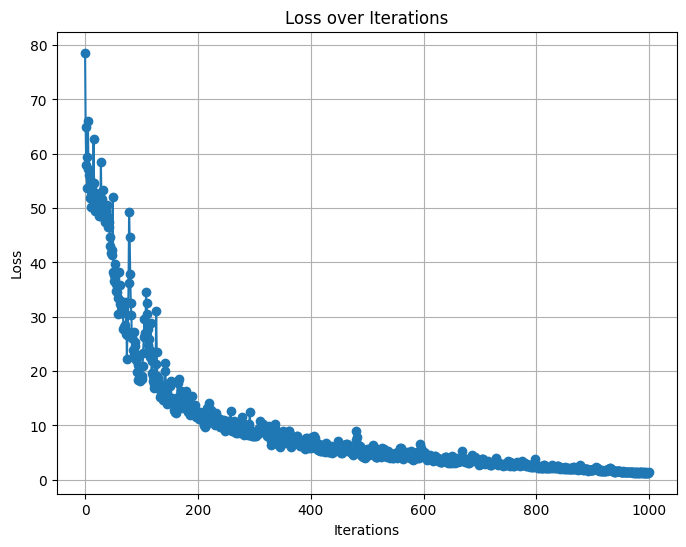

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(losses, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

[tensor(67.2627, device='cuda:0'), 67.26266479492188, tensor(35.7192, device='cuda:0'), 35.719173431396484, tensor(31.8300, device='cuda:0'), 31.82997703552246, tensor(89.6179, device='cuda:0'), 89.61791229248047, tensor(34.2020, device='cuda:0'), 34.20195007324219, tensor(257.9535, device='cuda:0'), 257.9534912109375, tensor(87.2554, device='cuda:0'), 87.25542449951172, tensor(89.7126, device='cuda:0'), 89.71257781982422, tensor(96.1228, device='cuda:0'), 96.12278747558594, tensor(23.4756, device='cuda:0'), 23.47561264038086, tensor(30.1143, device='cuda:0'), 30.114309310913086, tensor(15.6742, device='cuda:0'), 15.674161911010742, tensor(35.6276, device='cuda:0'), 35.62763595581055, tensor(17.5944, device='cuda:0'), 17.59443473815918, tensor(25.2214, device='cuda:0'), 25.221372604370117, tensor(251.7269, device='cuda:0'), 251.7268524169922, tensor(86.7455, device='cuda:0'), 86.7455062866211, tensor(22.7542, device='cuda:0'), 22.75423240661621, tensor(16.5361, device='cuda:0'), 16.536

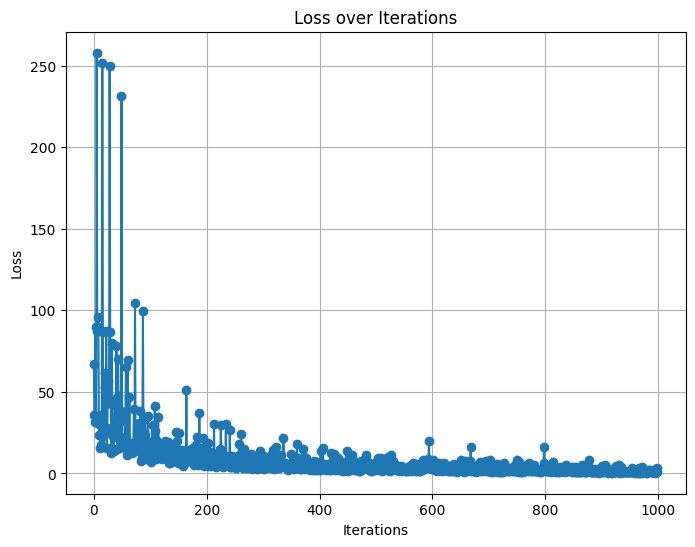

In [ ]:
m = []
for val in losses_validation:
  if type(val) == float:
    m.append(val)
print(losses_validation)
plt.figure(figsize=(8, 6))
plt.plot(m, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.grid(True)
plt.show()

In [ ]:
%reset -f


In [ ]:
dataset = HDRDataset(mode="test", opt=opt)

# split dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=1, random_state=42)

# create separate data loaders for training and validation
train_data_loader = DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
torch.cuda.empty_cache()
i = 0
device = torch.device("cuda")

model.to(device)
for batch in tqdm(train_data_loader):
        # Move the batch to the device
        input = batch['ldr_image']
        input = input.to(device)
        output_true = batch['hdr_image']
        output_true = output_true.to(device)

        output = model(input)



        save_hdr_image(
                img_tensor=output,
                batch=0,
                path="genmoxx{}.hdr".format(
                    i
                ),
        )
        save_hdr_image(
                img_tensor=output_true,
                batch=0,
                path="realmoxx{}.hdr".format(
                    i
                ),
            )



  0%|          | 0/4 [00:00<?, ?it/s]/content/drive/MyDrive/epce-hdr/util.py:55: RuntimeWarning: invalid value encountered in divide
  scaled_mantissa = mantissa * 255.0 / brightest
 25%|██▌       | 1/4 [00:02<00:06,  2.14s/it]


OutOfMemoryError: ignored

In [ ]:
import torch

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load your model
loaded_model =model

# Calculate the number of parameters
num_params = count_parameters(loaded_model)
print(f"The model has {num_params} parameters.")


The model has 35426357 parameters.
